# Travel Insurance Claim Prediction

## A. Business Problem Understanding

### Context
A company engaged in travel insurance wants to predict which policyholders will submit an insurance claim for travel coverage. Policyholder data includes information such as destination, travel insurance products, and historical data regarding claims. The ability to predict claim submissions can help the company better manage risk, allocate resources efficiently, and improve overall profitability.

Target:

0 : No claim submitted

1 : Claim submitted

### Problem Statement
Processing insurance claims can be costly and resource-intensive, especially if many claims are submitted unexpectedly. The company wants to minimize risk by predicting which policyholders are likely to submit a claim, allowing them to better manage reserves and optimize the pricing of premiums. By knowing which customers are likely to submit claims, the company can tailor its offers and reduce unnecessary costs.

### Goals
The company seeks to predict the likelihood of a customer filing a claim after purchasing a travel insurance policy. This would help them allocate resources efficiently, adjust premiums based on risk factors, and develop strategies to reduce claim submissions.

Additionally, the company wants to understand what factors drive customers to submit claims, allowing them to refine their offerings and provide better customer service while managing risk.

### Analytic Approach:
We will analyze the data to identify patterns that distinguish customers who submit claims from those who do not. Then, we will build a classification model to predict the likelihood of a policyholder submitting a claim, allowing the company to focus on high-risk customers for better risk management.

### Metric Evaluation:

We will focus on the following errors:

* Type 1 Error (False Positive):

    Predicting a customer will submit a claim when they will not.
    Consequence: Misallocated resources and increased risk reserves unnecessarily.

* Type 2 Error (False Negative):

    Predicting a customer will not submit a claim when they will.
    Consequence: Unprepared for claim submissions, leading to financial strain.

The main metric for evaluation will be roc_auc as it balances both precision and recall, ensuring that the model minimizes both false positives and false negatives while capturing true risks efficiently.


## B. Data Understanding

The dataset contains information about policyholders from a third-party travel insurance service company based in Singapore. 
Online Access: https://www.kaggle.com/datasets/mhdzahier/travel-insurance.

Here's Dataset's attribute informaton:

| Attribute               | Data Type, Length | Description                                           |
|-------------------------|-------------------|-------------------------------------------------------|
| Agency                  | Text              | The agency offering the insurance policy              |
| Agency Type             | Text              | Type of agency (e.g., Airlines, Travel Agency)        |
| Distribution Channel    | Text              | The method used for distributing the policy (Online)  |
| Product Name            | Text              | The name of the insurance product                     |
| Gender                  | Text              | Gender of the customer (M = Male, F = Female)         |
| Duration                | Integer           | Duration of the policy in days                        |
| Destination             | Text              | The destination where the policyholder is traveling   |
| Net Sales               | Float             | Total sales amount for the policy                     |
| Commision (in value)    | Float             | The commission earned for the policy sale             |
| Age                     | Integer           | Age of the policyholder                               |
| Claim                   | Text              | Whether a claim was made (Yes/No)                     |


In [80]:
# Libraries
import numpy as np
import pandas as pd
import warnings
import multiprocessing
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistics
from scipy.stats import shapiro, spearmanr, probplot, randint, uniform

# Data Imputation
from sklearn.impute import KNNImputer

# Encoding and Preprocessing
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder, StandardScaler, 
                                   RobustScaler, MinMaxScaler, PolynomialFeatures, 
                                   FunctionTransformer, PowerTransformer, OrdinalEncoder)
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from imblearn.pipeline import Pipeline, make_pipeline

# Sampling Methods
from imblearn.over_sampling import SMOTE

# Model Algorithms
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, VotingClassifier)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Evaluation and Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.model_selection import (train_test_split, cross_val_score, StratifiedKFold, 
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_selection import SelectPercentile, RFE

# Ignore warnings
warnings.filterwarnings('ignore')

In [3]:
df_raw = pd.read_csv('data_travel_insurance.csv')
df_raw.head()

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


In [20]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


> Insight:
* The dataset includes both categorical and numerical features. Categorical features include Agency, Product Name, Distribution Channel, and others, while numerical features are Net Sales, Commission (in value), and Duration.
* The Product Name and Agency columns may have high cardinality, representing a variety of different products and agencies.
* There are some missing values in the Gender column.
* Each row in the dataset represents an individual travel insurance policy and its associated details, such as the agency offering the policy, the type of product, the customer’s details, and the sales and claim information.

In [21]:
# Adjusting colomns name for easier data access
df_raw = df_raw.rename(columns={'Agency Type':'Agency_Type', 'Distribution Channel':'Distribution_Channel', 'Product Name':'Product_Name',
        'Net Sales':'Net_Sales','Commision (in value)':'Commision_in_value'})
df_raw['Claim'] = np.where(df_raw['Claim']=='Yes',1,0)

In [22]:
# Define feature and label
X = df_raw.drop('Claim', axis=1)
y = df_raw['Claim']

In [7]:
# Splitting data
X_train_all, X_test, y_train_all, y_test=train_test_split(X,y, test_size=0.3, stratify=y,random_state=10)

In [23]:
df = pd.concat([X_train_all, y_train_all], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
print(f'Train Dataset: {df.shape}')
display(df.head())
print(f'\n\n Test Dataset: {df_test.shape}')
display(df_test.head())

Train Dataset: (31029, 11)


,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim
38872,C2B,Airlines,Online,Bronze Plan,M,81,SINGAPORE,89.0,22.25,41,0
20551,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,INDONESIA,20.0,0.00,37,0
7775,C2B,Airlines,Online,Bronze Plan,F,4,SINGAPORE,16.0,4.00,63,0
43428,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,19,MALAYSIA,28.0,0.00,36,0
6951,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,10,THAILAND,26.0,0.00,38,0




 Test Dataset: (13299, 11)


,Agency,Agency_Type,Distribution_Channel,Product_Name,Gender,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim
13501,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,25,MALAYSIA,59.40,35.64,41,0
28762,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,26,LAO PEOPLE'S DEMOCRATIC REPUBLIC,38.00,0.00,36,0
21396,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,65,UNITED STATES,27.00,0.00,48,0
28921,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,68,PHILIPPINES,32.00,0.00,36,0
22151,C2B,Airlines,Online,Bronze Plan,M,3,SINGAPORE,14.95,3.74,39,0


> Insight:
* Splitting data should be done at the beginning, before preprocessing, to prevent data leakage in the test set.

## C. Data Cleaning

### 1. Adjusting Data Type

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31029 entries, 38872 to 41528
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                31029 non-null  object 
 1   Agency_Type           31029 non-null  object 
 2   Distribution_Channel  31029 non-null  object 
 3   Product_Name          31029 non-null  object 
 4   Gender                8922 non-null   object 
 5   Duration              31029 non-null  int64  
 6   Destination           31029 non-null  object 
 7   Net_Sales             31029 non-null  float64
 8   Commision_in_value    31029 non-null  float64
 9   Age                   31029 non-null  int64  
 10  Claim                 31029 non-null  int32  
dtypes: float64(2), int32(1), int64(2), object(6)
memory usage: 2.7+ MB


> Insight:
All the column type is correct due to information loaded.

### 2. Checking Data Values

In [26]:
# Checking each column unique value
listItem = []
for i in df.columns:
    count_unique = df[i].nunique()
    unique_value = df[i].unique()
    listItem.append([i, count_unique, unique_value])

unique_table = pd.DataFrame(data=listItem, columns=['Column Name', 'Count of Unique Value', 'Unique Values'])
unique_table

,Column Name,Count of Unique Value,Unique Values
0,Agency,16,"[C2B, EPX, JZI, CWT, LWC, JWT, TST, CCR, RAB, ..."
1,Agency_Type,2,"[Airlines, Travel Agency]"
2,Distribution_Channel,2,"[Online, Offline]"
3,Product_Name,26,"[Bronze Plan, 2 way Comprehensive Plan, Basic ..."
4,Gender,2,"[M, nan, F]"
5,Duration,416,"[81, 51, 4, 19, 10, 8, 3, 20, 5, 21, 82, 143, ..."
6,Destination,122,"[SINGAPORE, INDONESIA, MALAYSIA, THAILAND, CHI..."
7,Net_Sales,865,"[89.0, 20.0, 16.0, 28.0, 26.0, 39.6, 18.0, 63...."
8,Commision_in_value,798,"[22.25, 0.0, 4.0, 9.1, 23.76, 6.3, 10.5, 10.38..."
9,Age,85,"[41, 37, 63, 36, 38, 47, 56, 25, 27, 34, 21, 4..."


> Insight:
All the data values ​​in each column have been consistent, meaning there are no redundant terms for one value

### 3. Handling Outliers

In [27]:
df.columns

Index(['Agency', 'Agency_Type', 'Distribution_Channel', 'Product_Name',
       'Gender', 'Duration', 'Destination', 'Net_Sales', 'Commision_in_value',
       'Age', 'Claim'],
      dtype='object')

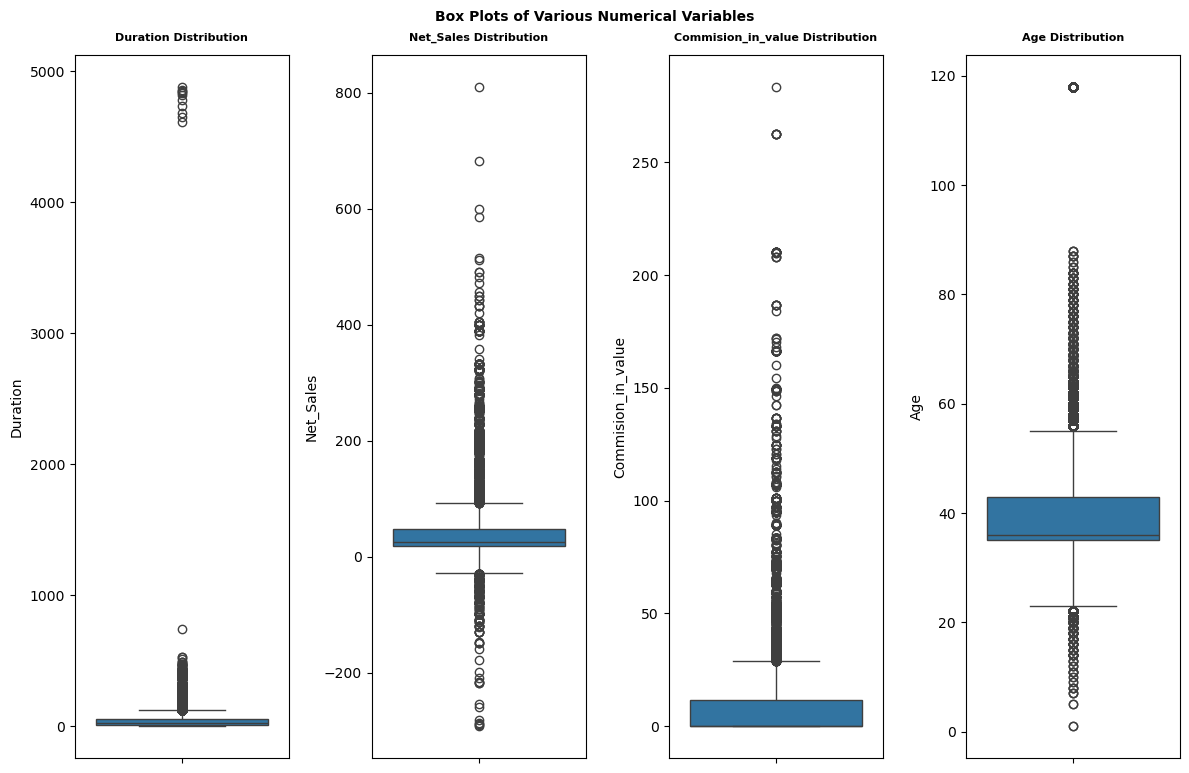

In [28]:
col = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 8))
axes = axes.flatten()

# Perbaikan dengan mengelola enumerate dengan benar
for i, c in enumerate(col):
    sns.boxplot(data=df, y=c, ax=axes[i])  # Gunakan c untuk setiap kolom
    axes[i].set_title(f'{c} Distribution', pad=10, fontweight='bold', fontsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(c)

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.suptitle('Box Plots of Various Numerical Variables', fontsize=10, fontweight='bold')
plt.show()


In [30]:
df.describe()

,Duration,Net_Sales,Commision_in_value,Age,Claim
count,31029.000000,31029.000000,31029.00000,31029.000000,31029.000000
mean,49.595250,40.588466,9.74052,39.965065,0.015276
std,115.427469,48.745513,19.51803,14.057037,0.122651
min,-1.000000,-291.750000,0.00000,1.000000,0.000000
25%,9.000000,18.000000,0.00000,35.000000,0.000000
50%,22.000000,26.000000,0.00000,36.000000,0.000000
75%,53.000000,48.000000,11.55000,43.000000,0.000000
max,4881.000000,810.000000,283.50000,118.000000,1.000000


In [31]:
df = df[df['Duration']>=0]
df = df[df['Net_Sales']>=0]
df = df[(df['Age']>=0) & (df['Age']<100)]

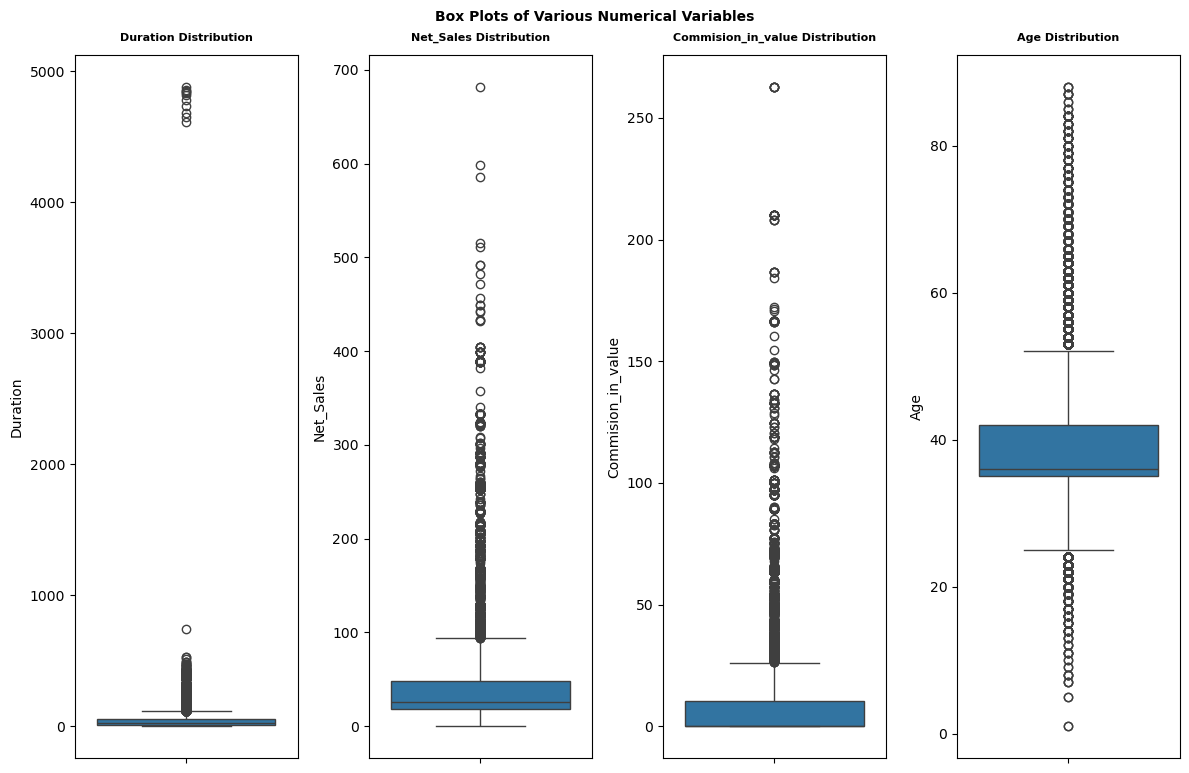

In [32]:
col = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 8))
axes = axes.flatten()

# Perbaikan dengan mengelola enumerate dengan benar
for i, c in enumerate(col):
    sns.boxplot(data=df, y=c, ax=axes[i])  # Gunakan c untuk setiap kolom
    axes[i].set_title(f'{c} Distribution', pad=10, fontweight='bold', fontsize=8)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(c)

plt.tight_layout(rect=[0, 0.02, 1, 0.97])
plt.suptitle('Box Plots of Various Numerical Variables', fontsize=10, fontweight='bold')
plt.show()

> Insight:
* Negative values in the Duration column have been removed since time cannot be negative.
* Negative values in the Net_Sales column have been eliminated, as sales prices should not logically fall below zero.
* The Age column has been limited to a range of 0 to 100 to exclude unrealistic or erroneous data entries.

### 4. Handle Missing Values

In [33]:
# Count Proportion Missing Value
counts = df['Gender'].value_counts(dropna=False)
total = counts.sum()
proportions = counts / total * 100
for value, proportion in proportions.items():
    if pd.isna(value):  # Handle missing values
        print(f"Total missing values in Gender column = {proportion:.2f}%")
    else:
        print(f"{value} = {proportion:.2f}%")

Total missing values in Gender column = 71.97%
M = 14.12%
F = 13.91%


In [34]:
# Drop column and check wether there's any missing values
df = df.drop(['Gender'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30206 entries, 38872 to 41528
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                30206 non-null  object 
 1   Agency_Type           30206 non-null  object 
 2   Distribution_Channel  30206 non-null  object 
 3   Product_Name          30206 non-null  object 
 4   Duration              30206 non-null  int64  
 5   Destination           30206 non-null  object 
 6   Net_Sales             30206 non-null  float64
 7   Commision_in_value    30206 non-null  float64
 8   Age                   30206 non-null  int64  
 9   Claim                 30206 non-null  int32  
dtypes: float64(2), int32(1), int64(2), object(5)
memory usage: 2.4+ MB


> Insight: The Gender column in the dataset had 71.97% missing values, which is significantly high. Due to the large proportion of missing data, it was not practical to use an imputer to fill the missing values. Therefore, the Gender column was dropped from the dataset to maintain data integrity and to avoid introducing bias or inaccuracies with imputation methods.

### 5. Checking Duplicate Data

In [35]:
# Find whether data is duplicate
print(f"Sum of duplicates rows in this dataset: {df.duplicated().sum()}")

Sum of duplicates rows in this dataset: 2721


In [36]:
# Handling duplicate rows
df.drop_duplicates(inplace=True)
if df.duplicated().sum() > 0:
    print(f"Sum of duplicates rows in this dataset: {df.duplicated().sum()}")
else:
    print("There's no more duplicate rows")

There's no more duplicate rows


> Insight:
The dataset had 2721 duplicate rows, which were removed to prevent issues model bias, overfitting, and inaccurate predictions that leading to incorrect predictions and reducing the model's performance.

## D. Exploratory Data Analysis

In [37]:
df_cleaned = df.copy()

### 1. Statistik Deskriptif

In [38]:
print('Descriptive Statistics for numeric columns:')
display(df_cleaned.select_dtypes(include = 'number').describe())
print('Descriptive Statistics for categoric columns:')
display(df_cleaned.select_dtypes(exclude = 'number').describe())

Descriptive Statistics for numeric columns:


,Duration,Net_Sales,Commision_in_value,Age,Claim
count,27485.000000,27485.000000,27485.000000,27485.000000,27485.000000
mean,51.817464,43.071904,9.993364,38.948772,0.017027
std,120.285891,48.054428,19.874780,10.451223,0.129376
min,0.000000,0.000000,0.000000,1.000000,0.000000
25%,10.000000,19.800000,0.000000,34.000000,0.000000
50%,24.000000,28.000000,0.000000,36.000000,0.000000
75%,55.000000,49.500000,11.720000,44.000000,0.000000
max,4881.000000,682.000000,262.760000,88.000000,1.000000


Descriptive Statistics for categoric columns:


,Agency,Agency_Type,Distribution_Channel,Product_Name,Destination
count,27485,27485,27485,27485,27485
unique,15,2,2,26,120
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE
freq,14956,19723,27028,7849,5834


### 2. Univariate Analysis

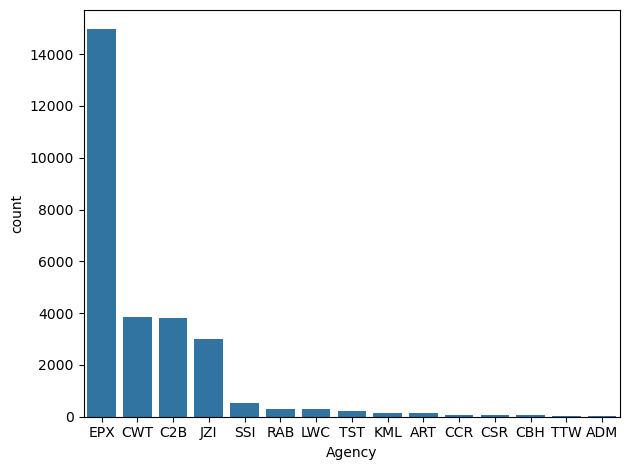

In [39]:
sns.countplot(data=df_cleaned, x='Agency', order=df_cleaned['Agency'].value_counts().index)
plt.tight_layout()
plt.show()

> Insight: Majority of customers have enrolled with the EPX travel agency.

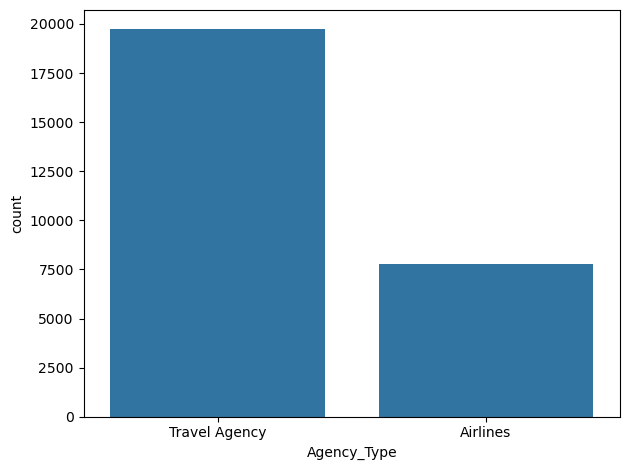

In [40]:
sns.countplot(data=df_cleaned, x='Agency_Type', order=df_cleaned['Agency_Type'].value_counts().index)
plt.tight_layout()
plt.show()

> Insight: Customers partnered more with Travel Agency than with Airlines.

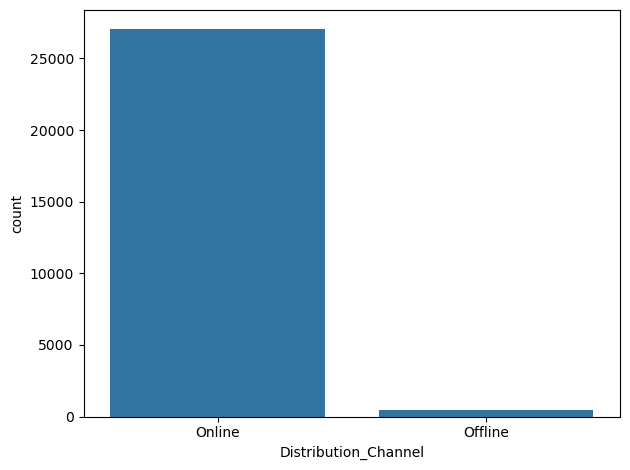

In [41]:
sns.countplot(data=df_cleaned, x='Distribution_Channel', order=df_cleaned['Distribution_Channel'].value_counts().index)
plt.tight_layout()
plt.show()

> Insight: Customers prefer apply by online channel than offline. 

In [42]:
df_cleaned.columns

Index(['Agency', 'Agency_Type', 'Distribution_Channel', 'Product_Name',
       'Duration', 'Destination', 'Net_Sales', 'Commision_in_value', 'Age',
       'Claim'],
      dtype='object')

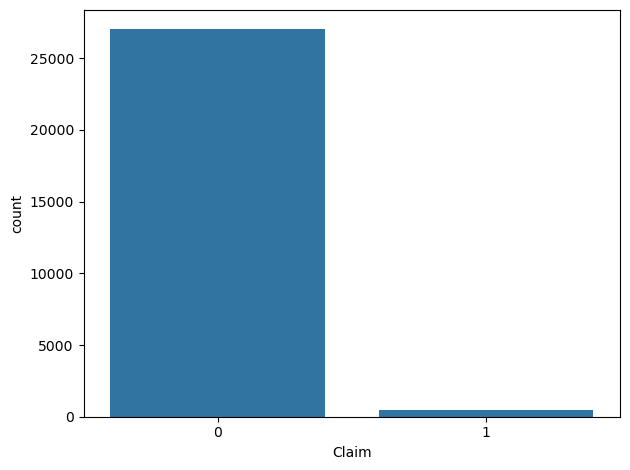

In [43]:
sns.countplot(data=df_cleaned, x='Claim', order=df_cleaned['Claim'].value_counts().index)
plt.tight_layout()
plt.show()

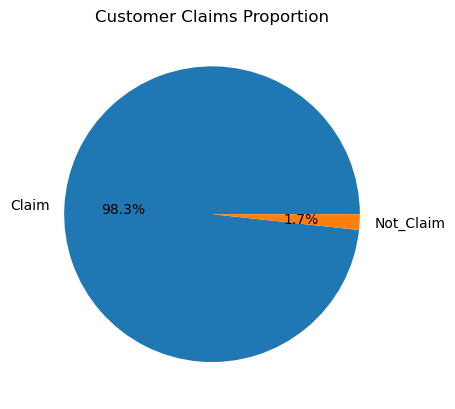

In [44]:
train_agg=df_cleaned['Claim'].value_counts(normalize=1).reset_index()
train_agg['percentage']=100*train_agg['proportion']
train_agg


plt.pie(data=train_agg,x='percentage',labels=['Claim','Not_Claim'], autopct='%1.1f%%'
       ,textprops=dict())
plt.title('Customer Claims Proportion')
plt.show()

> Insight: There are more customers who don't claim their insurance than those who do. This indicates that this is a highly imbalanced data set that will need to be balanced later to ensure that it does not adversely impact the performance of the machine learning algorithm.

### 3. Bivariate Analysis

In [45]:
train_label = df_cleaned.select_dtypes(include='number')
train_label

,Duration,Net_Sales,Commision_in_value,Age,Claim
38872,81,89.0,22.25,41,0
20551,51,20.0,0.00,37,0
7775,4,16.0,4.00,63,0
43428,19,28.0,0.00,36,0
6951,10,26.0,0.00,38,0
...,...,...,...,...,...
4148,6,29.7,17.82,37,0
41051,40,17.0,0.00,36,0
8477,30,30.0,0.00,36,0
36829,2,10.0,0.00,46,0


Duration


,bin_Duration,Claim
0,"(-0.001, 14.0]",0.012470
1,"(14.0, 41.0]",0.015405
2,"(41.0, 4881.0]",0.023428


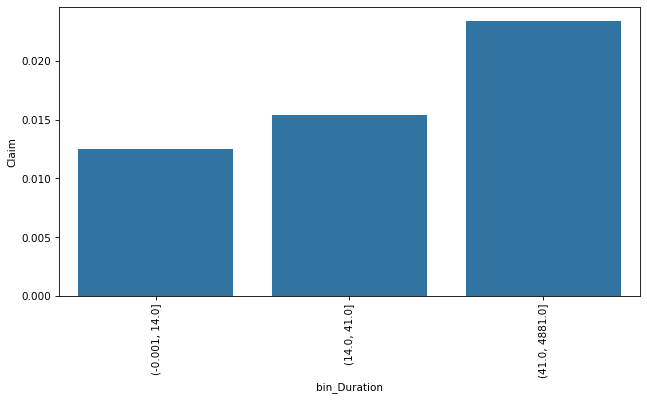

Net_Sales


,bin_Net_Sales,Claim
0,"(-0.001, 20.0]",0.006452
1,"(20.0, 39.6]",0.013001
2,"(39.6, 682.0]",0.032440


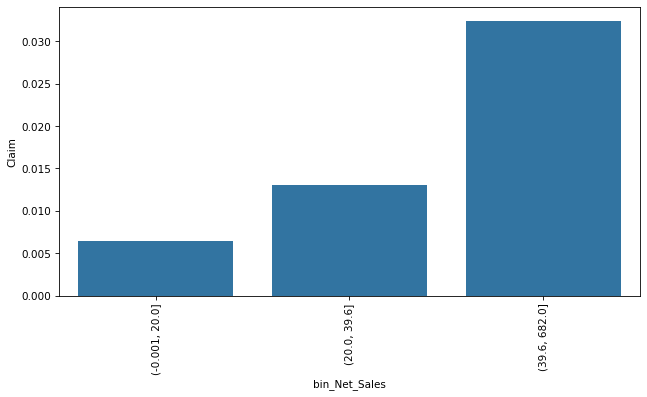

Commision_in_value


,bin_Commision_in_value,Claim
0,"(-0.001, 7.7]",0.009322
1,"(7.7, 262.76]",0.033934


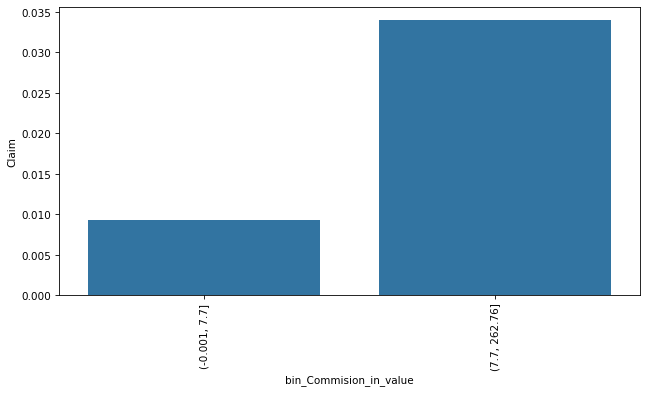

Age


,bin_Age,Claim
0,"(0.999, 36.0]",0.016809
1,"(36.0, 38.0]",0.016779
2,"(38.0, 88.0]",0.017490


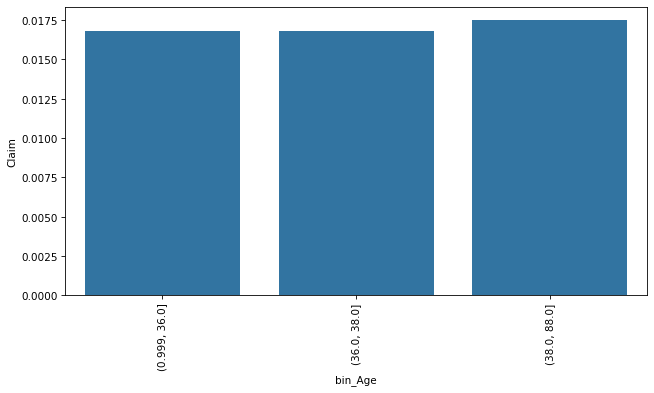

In [46]:
for x in train_label.columns:
    if x != 'Claim':
        print(x)
        
        # Buat binning menggunakan qcut
        train_label[f'bin_{x}'] = pd.qcut(train_label[x], 3, duplicates='drop')
        
        # Kelompokkan berdasarkan bin dan hitung rata-rata survived
        train_label_agg = train_label.groupby(f'bin_{x}')['Claim'].mean().reset_index()
        
        # Konversi kategori bin menjadi string agar lebih aman saat plotting
        train_label_agg[f'bin_{x}'] = train_label_agg[f'bin_{x}'].astype(str)
        
        # Tampilkan hasil pengelompokan
        display(train_label_agg)
        
        # Plot hasilnya
        plt.figure(figsize=(10, 5), dpi=75)
        sns.barplot(data=train_label_agg, x=f'bin_{x}', y='Claim')
        plt.xticks(rotation=90)
        plt.show()

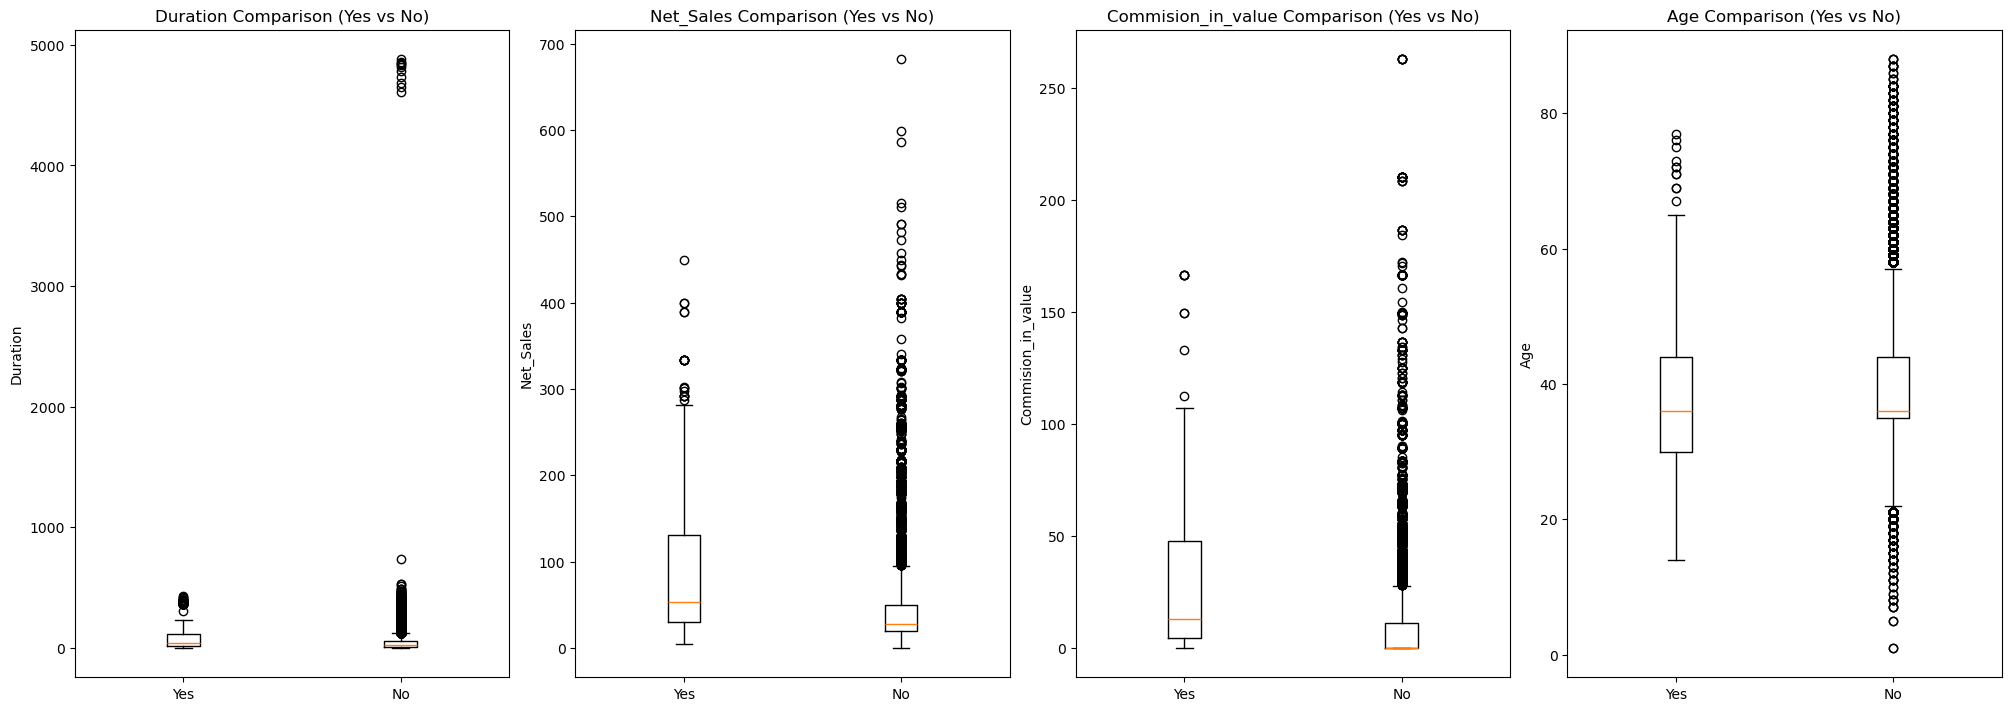

In [92]:
claim_yes = train_label[train_label['Claim'] == 1]
claim_no = train_label[train_label['Claim'] == 0]

num_cols = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']

fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 7), constrained_layout=True)

for ax, col in zip(axes, num_cols):
    ax.boxplot([claim_yes[col], claim_no[col]])
    ax.set_xticklabels(['Yes', 'No'])
    ax.set_ylabel(col)
    ax.set_title(f'{col} Comparison (Yes vs No)')

plt.show()


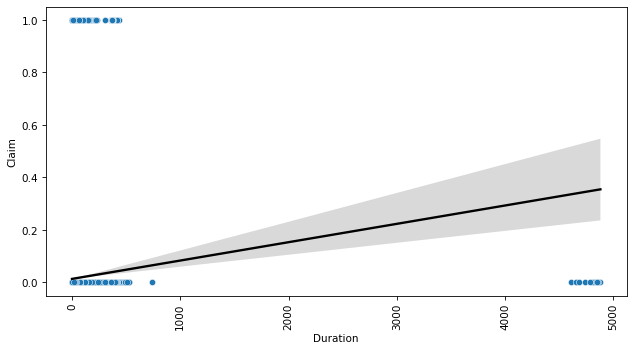

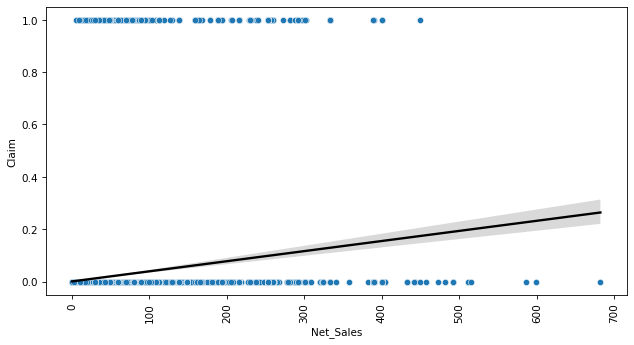

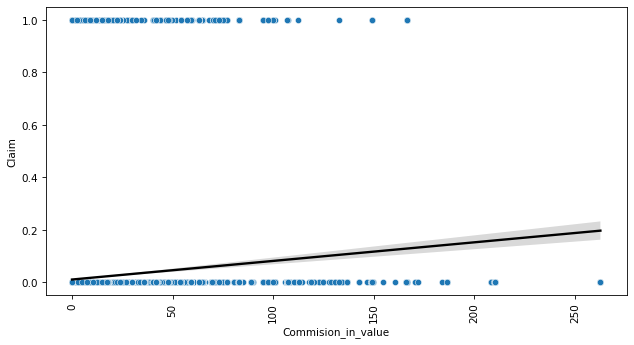

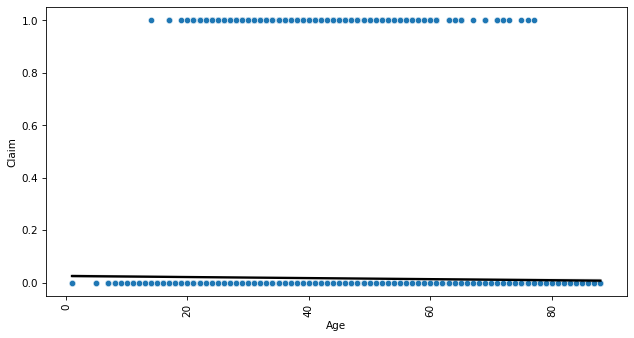

In [47]:
for x in train_label.select_dtypes(include='number').columns:
    if x !='Claim':
        # Plot hasilnya
        plt.figure(figsize=(10, 5), dpi=75)
        sns.scatterplot(data=train_label, x=x, y='Claim')
        sns.regplot(data=train_label, x=x, y='Claim',scatter=False,color='black')
        plt.xticks(rotation=90)
        plt.show()
    else:
        continue


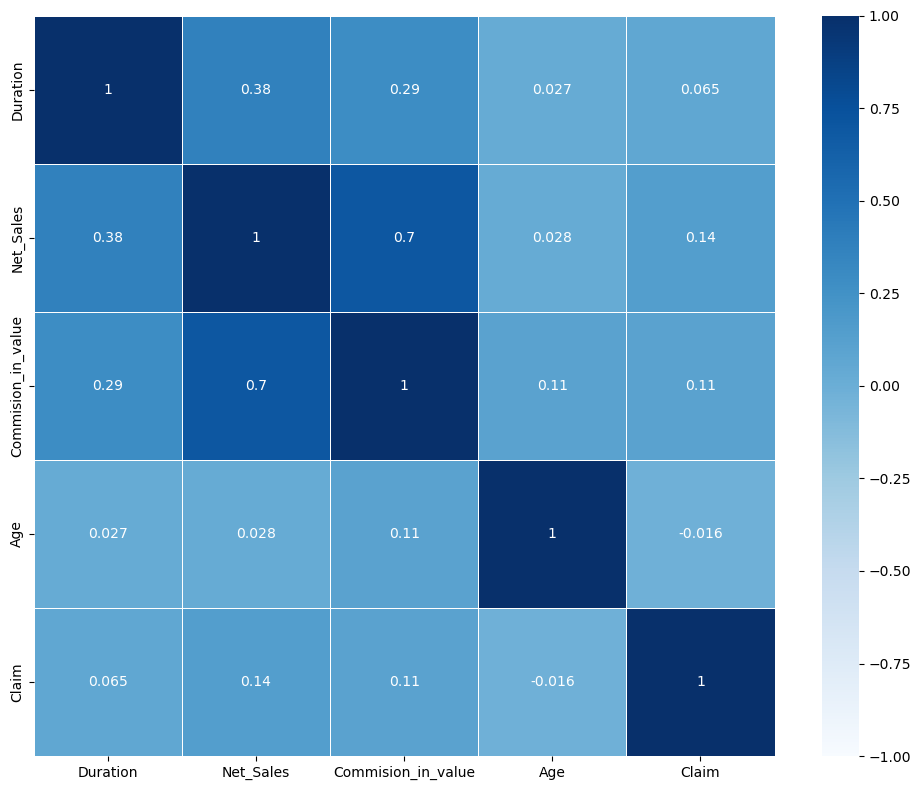

In [48]:
# Plot korelasi
corr = df_cleaned.select_dtypes(include='number').corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='Blues', annot=True, center=0, vmin=-1, square=True, linewidths=.5)
plt.tight_layout()
plt.show()

> Insight: There is a significant positive correlation between the features, "Net_Sales" and "Commission".

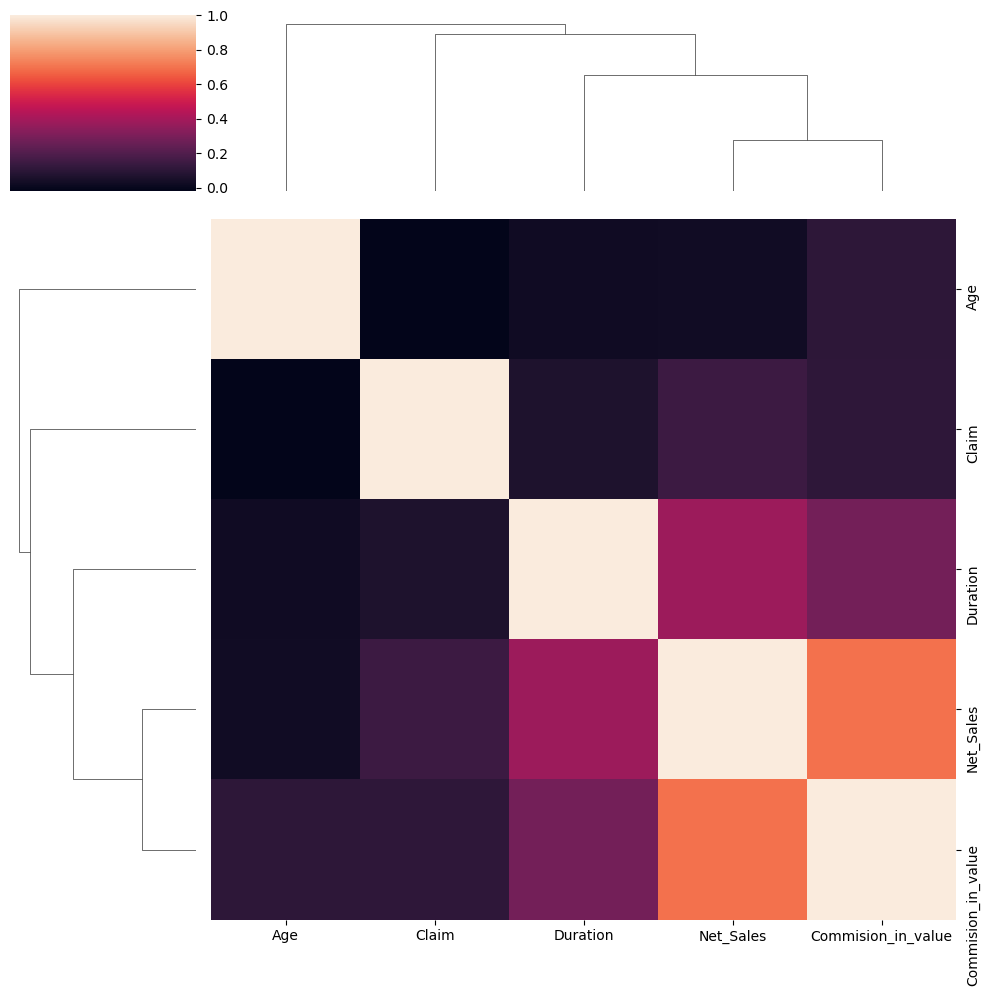

In [49]:
sns.clustermap(df_cleaned.select_dtypes(include='number').corr())
plt.tight_layout()

### 4. Multivariate Analysis

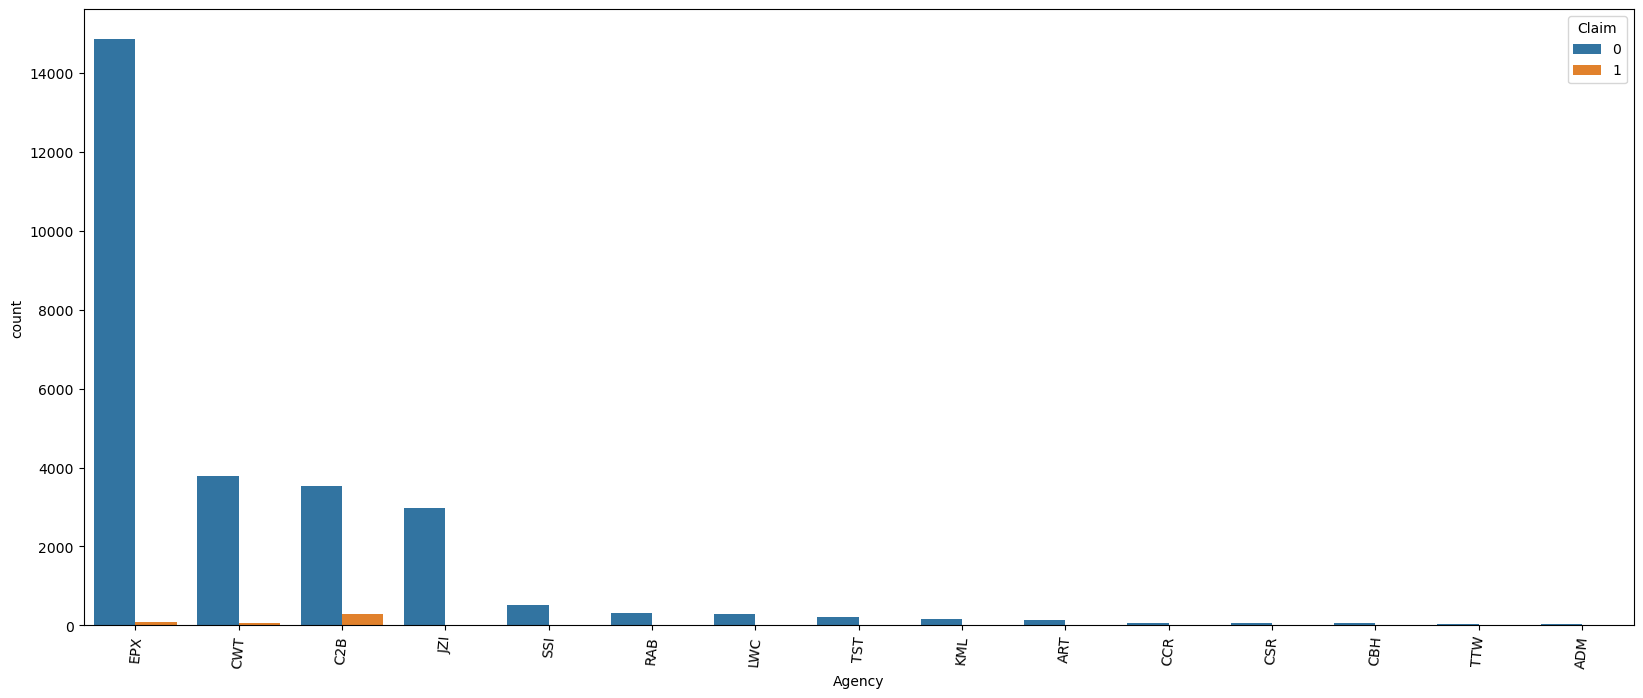

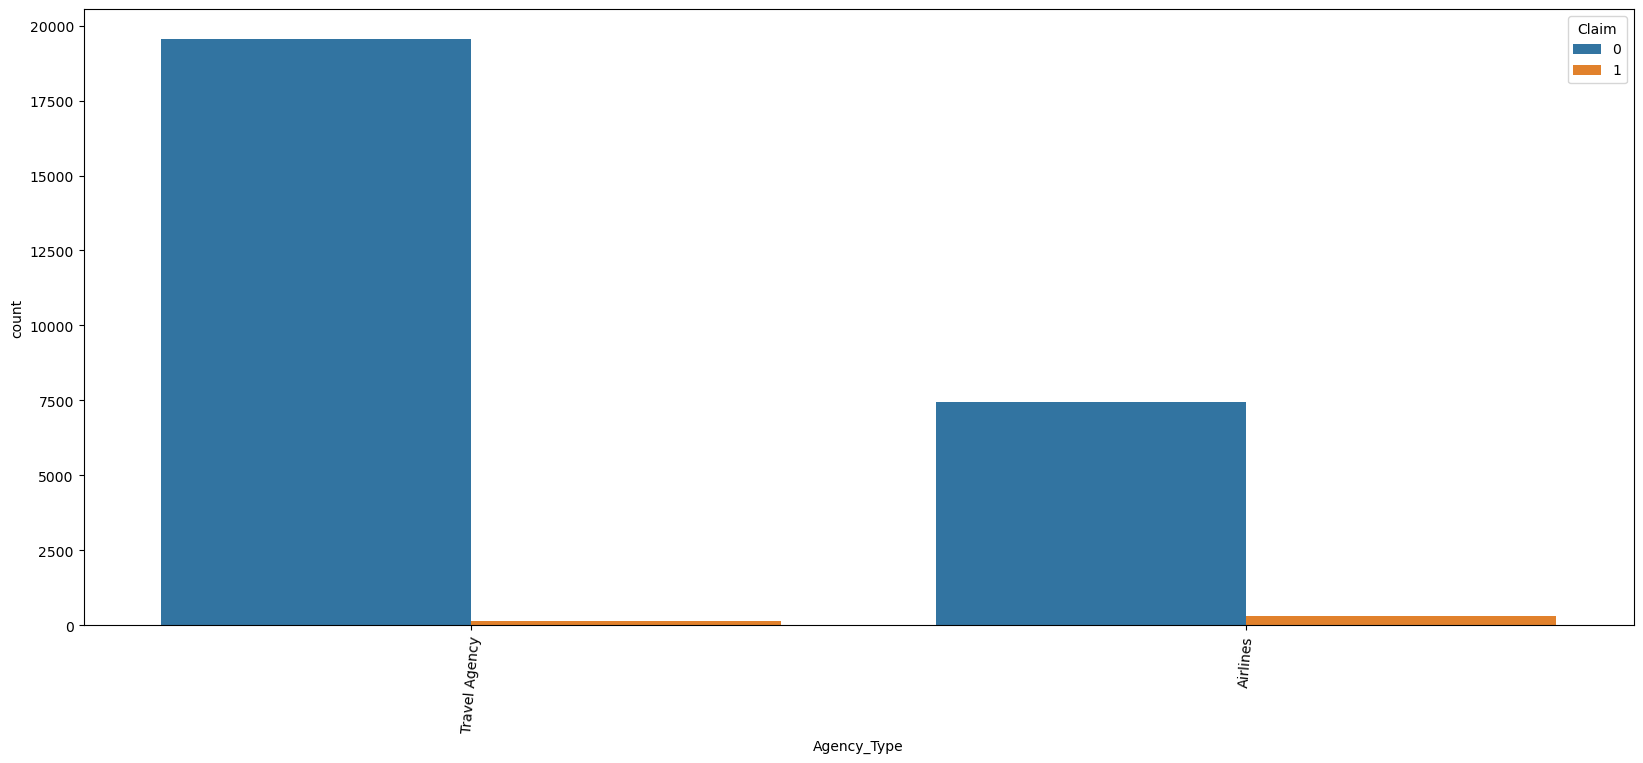

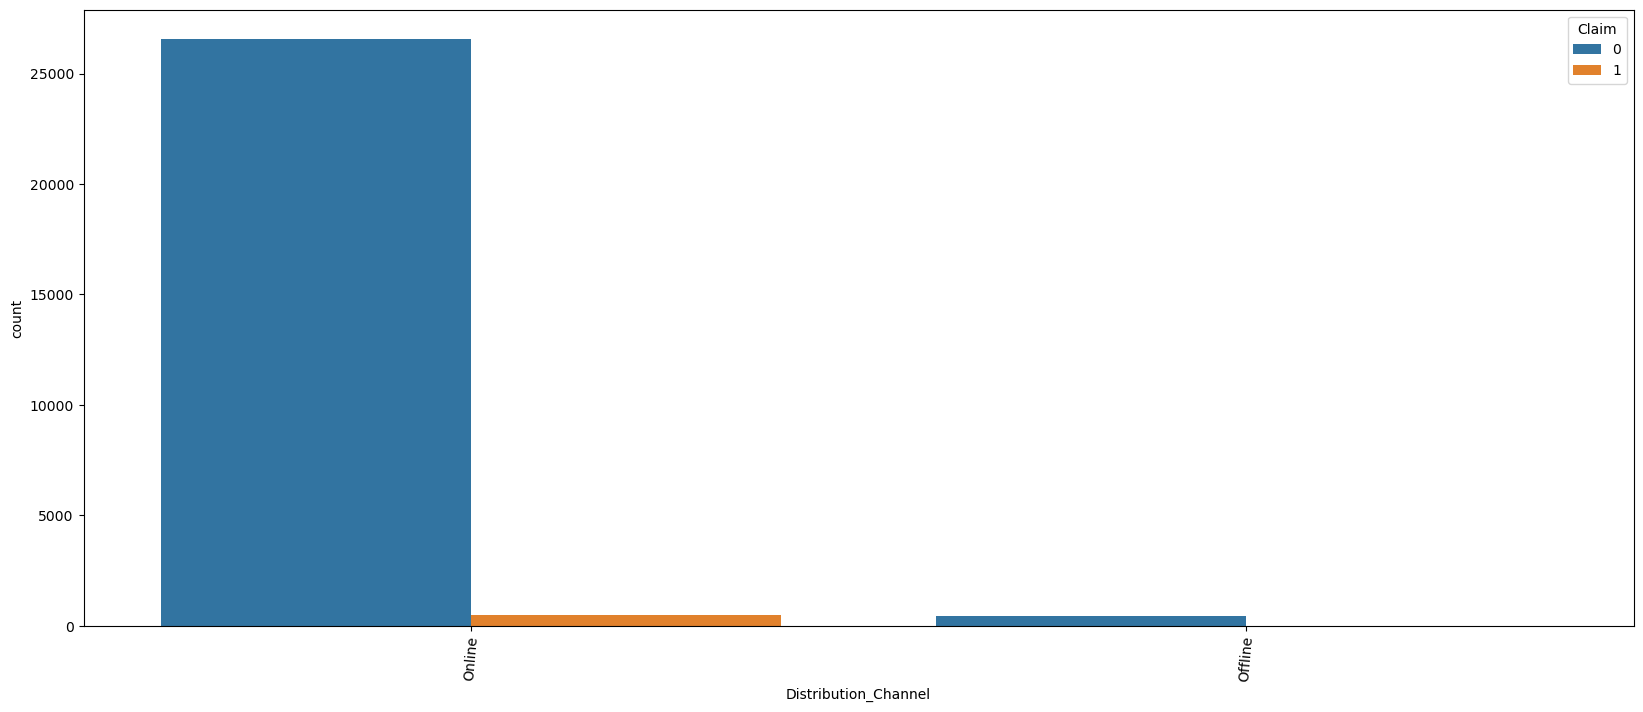

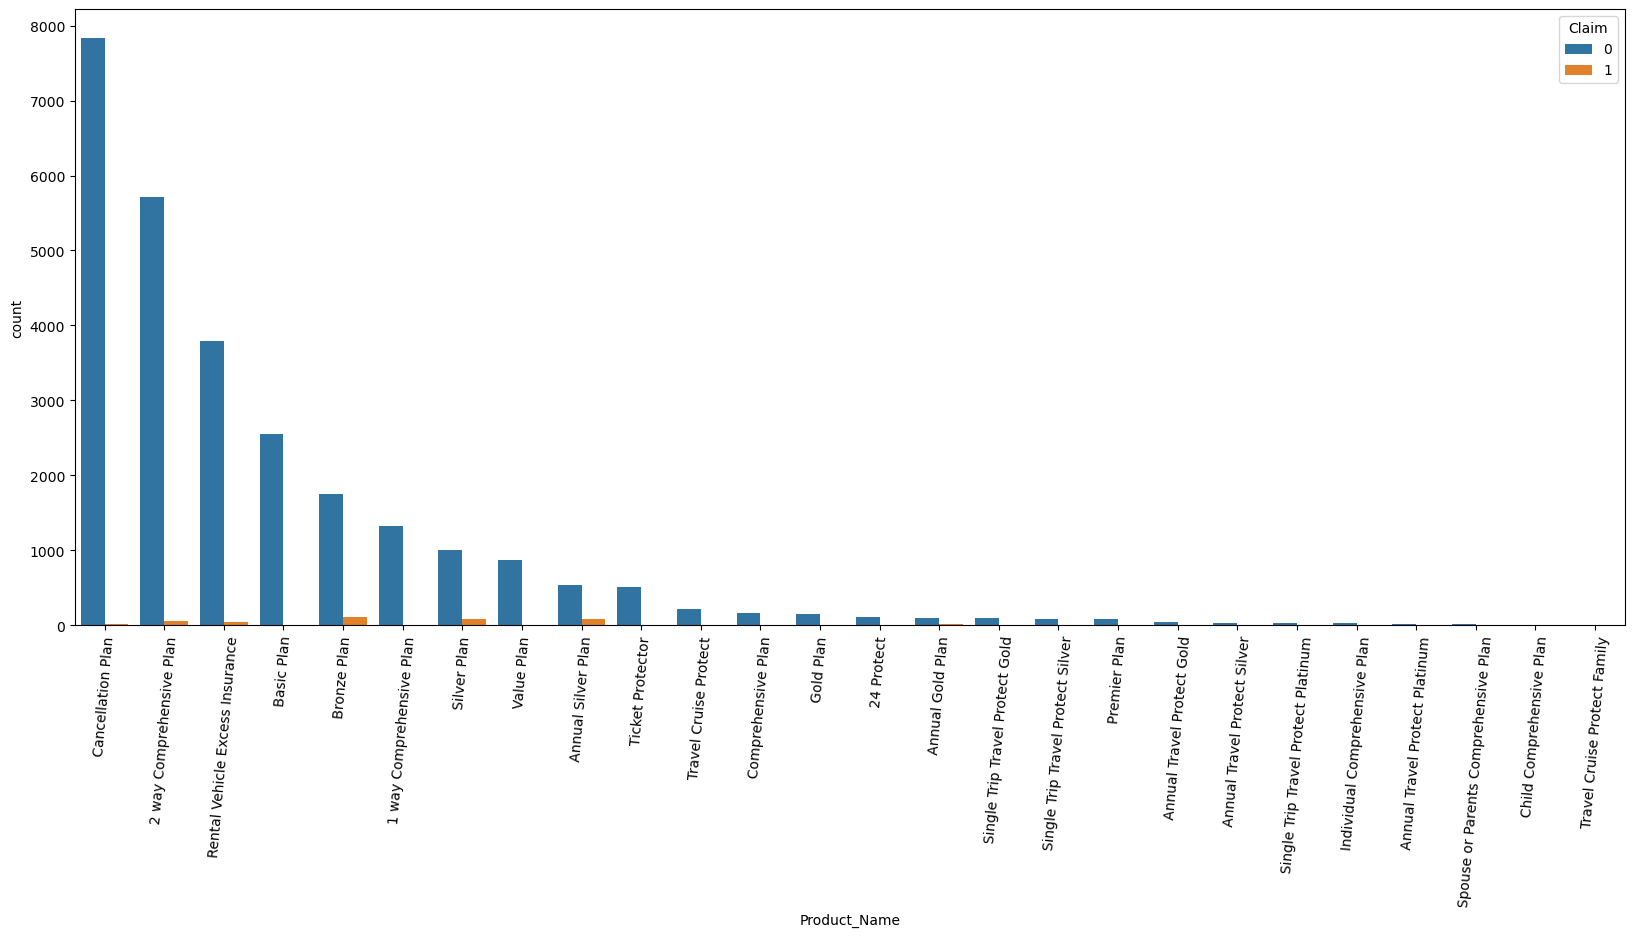

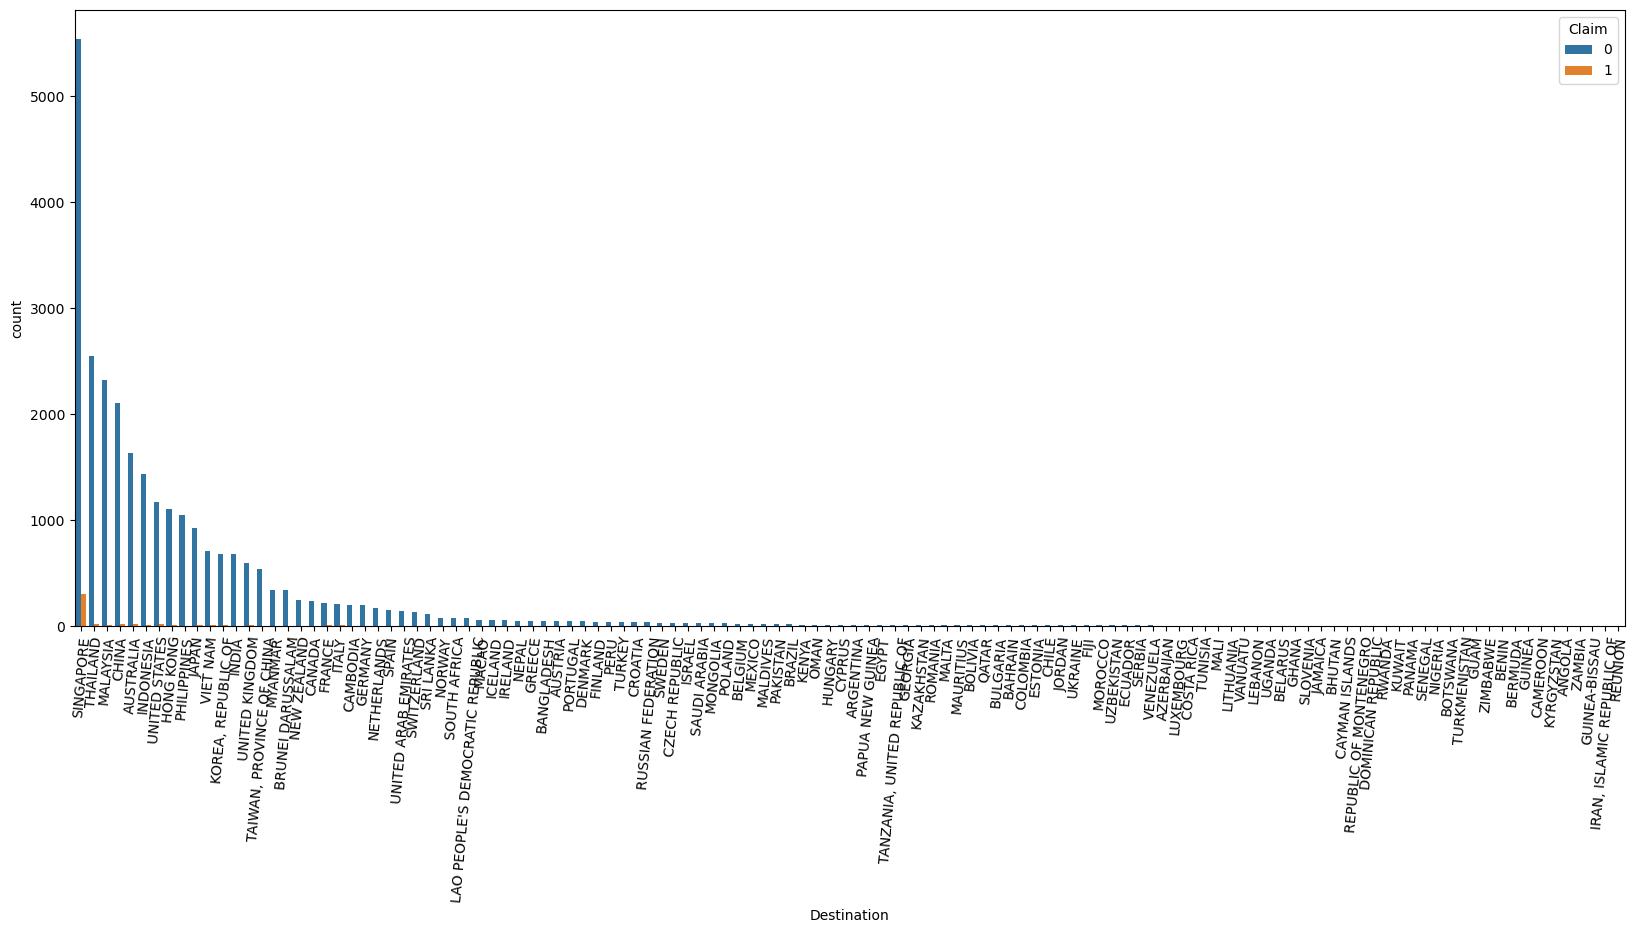

In [50]:
for x in df_cleaned.select_dtypes(include='object'):
    plt.figure(figsize=(20, 8), dpi=100)
    
    # Hitung frekuensi nilai dari kolom kategorikal
    count_values = df_cleaned[x].value_counts(ascending=False)
    
    # Plot countplot dengan urutan sesuai jumlah kemunculan
    ax = sns.countplot(data=df_cleaned, x=x, hue='Claim',order=count_values.index)
    
    # Rotasi label sumbu-x agar lebih mudah dibaca
    plt.xticks(rotation=85)
    


    plt.show()

## E. Model Prediction

## 1. Rule Based Model

In [89]:
df_clean = df.copy()

### a. Feature Engineering

In [112]:
df_clean.columns

Index(['Distribution_Channel', 'Destination', 'Net_Sales',
       'Commision_in_value', 'Age', 'Claim', 'Product_Encoded',
       'Duration_binned'],
      dtype='object')

* Agency, Agency_Type, Product_Name

In [96]:
# Initialize an empty DataFrame
consolidated_df = pd.DataFrame()


# Loop through each agency
for agency in df_clean['Agency'].unique():
    # Calculate mean Net_Sales for each Product_Name within the current agency
    mean_sales = df_clean[df_clean['Agency'] == agency].groupby('Product_Name')['Net_Sales'].mean().sort_values(ascending=False)

    # Create a DataFrame from the mean_sales Series
    temp_df = mean_sales.reset_index()
    temp_df['Agency'] = agency  # Add a column for the Agency

    # Append the results to the consolidated DataFrame
    consolidated_df = pd.concat([consolidated_df, temp_df], ignore_index=True)
    consolidated_df.drop(columns='Net_Sales', inplace=True)
    consolidated_df['Product_Encoded'] = consolidated_df.index + 1

# Display the final consolidated DataFrame
display(consolidated_df)


,Product_Name,Agency,Product_Encoded
0,Annual Gold Plan,C2B,1
1,Annual Silver Plan,C2B,2
2,Gold Plan,C2B,3
3,Silver Plan,C2B,4
4,Bronze Plan,C2B,5
5,2 way Comprehensive Plan,EPX,6
6,1 way Comprehensive Plan,EPX,7
7,Cancellation Plan,EPX,8
8,Value Plan,JZI,9
9,Premier Plan,JZI,10


In [97]:
# Create a mapping dictionary
encoding_dict = {row[['Agency', 'Product_Name']].values.tobytes(): row['Product_Encoded'] for index, row in consolidated_df.iterrows()}

# Apply the encoding to df_clean
df_clean['Product_Encoded'] = df_clean.apply(lambda row: encoding_dict.get(row[['Agency', 'Product_Name']].values.tobytes()), axis=1)
df_clean.head()


,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded
38872,C2B,Airlines,Online,Bronze Plan,81,SINGAPORE,89.0,22.25,41,0,5
20551,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,INDONESIA,20.0,0.00,37,0,6
7775,C2B,Airlines,Online,Bronze Plan,4,SINGAPORE,16.0,4.00,63,0,5
43428,EPX,Travel Agency,Online,2 way Comprehensive Plan,19,MALAYSIA,28.0,0.00,36,0,6
6951,EPX,Travel Agency,Online,2 way Comprehensive Plan,10,THAILAND,26.0,0.00,38,0,6


In [98]:
df_clean.drop(columns=['Agency', 'Agency_Type', 'Product_Name'], inplace=True)
df_clean.head()

,Distribution_Channel,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded
38872,Online,81,SINGAPORE,89.0,22.25,41,0,5
20551,Online,51,INDONESIA,20.0,0.00,37,0,6
7775,Online,4,SINGAPORE,16.0,4.00,63,0,5
43428,Online,19,MALAYSIA,28.0,0.00,36,0,6
6951,Online,10,THAILAND,26.0,0.00,38,0,6


* Duration

In [110]:
# Define bins and labels based on the distribution
duration_bins = [0, 10, 50, 100, 500, 1000, 2000, 5000]
duration_labels = ['0-10', '11-50', '51-100', '101-500', '501-1000', '1001-2000', '2001-5000']

# Apply the binning to the 'Duration' column
df_clean['Duration_binned'] = pd.cut(df_clean['Duration'], bins=duration_bins, labels=duration_labels, right=False)
# df_clean.drop(columns='Duration', inplace=True)
df_clean

,Distribution_Channel,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded,Duration_binned
38872,Online,SINGAPORE,89.0,22.25,41,0,5,51-100
20551,Online,INDONESIA,20.0,0.00,37,0,6,51-100
7775,Online,SINGAPORE,16.0,4.00,63,0,5,0-10
43428,Online,MALAYSIA,28.0,0.00,36,0,6,11-50
6951,Online,THAILAND,26.0,0.00,38,0,6,11-50
...,...,...,...,...,...,...,...,...
4148,Online,MALAYSIA,29.7,17.82,37,0,12,0-10
41051,Online,NEPAL,17.0,0.00,36,0,8,11-50
8477,Online,PHILIPPINES,30.0,0.00,36,0,8,11-50
36829,Online,THAILAND,10.0,0.00,46,0,8,0-10


In [119]:
df_clean['Net_Sales'].describe()

count    27485.000000
mean        43.071904
std         48.054428
min          0.000000
25%         19.800000
50%         28.000000
75%         49.500000
max        682.000000
Name: Net_Sales, dtype: float64

In [121]:
# Define bins and labels for 'Net_Sales' based on the distribution
net_sales_bins = [0, 10, 20, 30, 50, 100, 300, 700]
net_sales_labels = ['0-10', '11-20', '21-30', '31-50', '51-100', '101-300', '301-700']

# Apply the binning to the 'Net_Sales' column
df_clean['Net_Sales_Binned'] = pd.cut(df_clean['Net_Sales'], bins=net_sales_bins, labels=net_sales_labels, right=False)
df_clean


,Distribution_Channel,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded,Duration_binned,Net_Sales_binned,Net_Sales_Binned
38872,Online,SINGAPORE,89.0,22.25,41,0,5,51-100,51-100,51-100
20551,Online,INDONESIA,20.0,0.00,37,0,6,51-100,21-30,21-30
7775,Online,SINGAPORE,16.0,4.00,63,0,5,0-10,11-20,11-20
43428,Online,MALAYSIA,28.0,0.00,36,0,6,11-50,21-30,21-30
6951,Online,THAILAND,26.0,0.00,38,0,6,11-50,21-30,21-30
...,...,...,...,...,...,...,...,...,...,...
4148,Online,MALAYSIA,29.7,17.82,37,0,12,0-10,21-30,21-30
41051,Online,NEPAL,17.0,0.00,36,0,8,11-50,11-20,11-20
8477,Online,PHILIPPINES,30.0,0.00,36,0,8,11-50,31-50,31-50
36829,Online,THAILAND,10.0,0.00,46,0,8,0-10,11-20,11-20


In [127]:
# Define bins and labels for the 'Age' column based on the distribution
age_bins = [0, 18, 30, 40, 50, 65, 90]
age_labels = ['0-18', '19-30', '31-40', '41-50', '51-65', '66-90']

# Apply the binning to the 'Age' column
df_clean['Age_Binned'] = pd.cut(df_clean['Age'], bins=age_bins, labels=age_labels, right=False)
df_clean

,Distribution_Channel,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded,Duration_binned,Net_Sales_binned,Net_Sales_Binned,Age_binned,Age_Binned
38872,Online,SINGAPORE,89.0,22.25,41,0,5,51-100,51-100,51-100,41-50,41-50
20551,Online,INDONESIA,20.0,0.00,37,0,6,51-100,21-30,21-30,31-40,31-40
7775,Online,SINGAPORE,16.0,4.00,63,0,5,0-10,11-20,11-20,51-65,51-65
43428,Online,MALAYSIA,28.0,0.00,36,0,6,11-50,21-30,21-30,31-40,31-40
6951,Online,THAILAND,26.0,0.00,38,0,6,11-50,21-30,21-30,31-40,31-40
...,...,...,...,...,...,...,...,...,...,...,...,...
4148,Online,MALAYSIA,29.7,17.82,37,0,12,0-10,21-30,21-30,31-40,31-40
41051,Online,NEPAL,17.0,0.00,36,0,8,11-50,11-20,11-20,31-40,31-40
8477,Online,PHILIPPINES,30.0,0.00,36,0,8,11-50,31-50,31-50,31-40,31-40
36829,Online,THAILAND,10.0,0.00,46,0,8,0-10,11-20,11-20,41-50,41-50


### Model Build

In [103]:
def claim_frequencies(data, column, figsize=(8, 5)):
    # Calculate the counts of claimed (1) or unclaimed (0) values for each unique variable
    claim_counts = data.groupby(column)['Claim'].value_counts().unstack(fill_value=0)

    # Sort the table in descending order based on the 'Yes' claims column (1)
    if 1 in claim_counts.columns:
        table_sorted = claim_counts.sort_values(1, ascending=False)
    else:
        table_sorted = claim_counts

    # Create a new figure and axes with the desired size
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the side-by-side bar chart
    table_sorted.plot(kind='bar', stacked=False, ax=ax)

    # Set the title and labels
    ax.set_title(f'Claim Frequencies by {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend(['No Claim (0)', 'Claim (1)'], loc='upper right')

    # Display the chart
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to fit the labels
    plt.show()

    # Create Proportion Claims Table
    total_yes_claims = data[data['Claim'] == 1]['Claim'].count()

    if total_yes_claims > 0:
        table_percentage = round((table_sorted[1] / total_yes_claims) * 100, 2)
        table_sorted['Claimed Percentage'] = table_percentage.astype(str) + '%'

    print('-------Proportion Table-------')
    print(table_sorted)


In [105]:
df_clean.columns

Index(['Distribution_Channel', 'Duration', 'Destination', 'Net_Sales',
       'Commision_in_value', 'Age', 'Claim', 'Product_Encoded'],
      dtype='object')

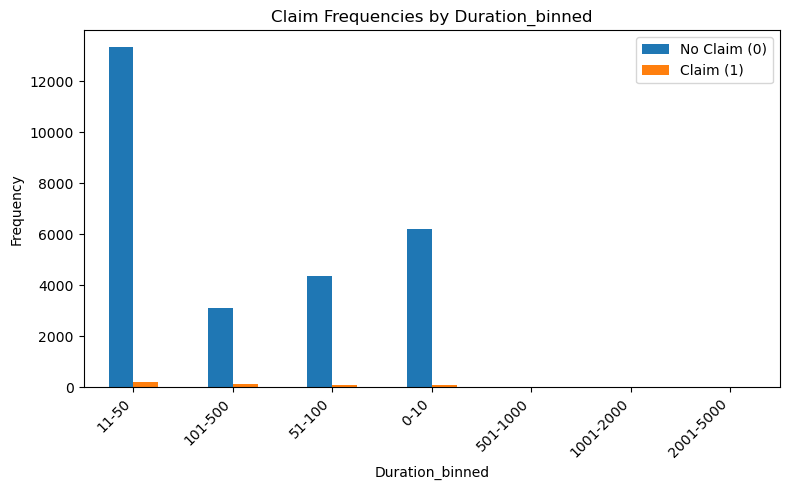

-------Proportion Table-------
Claim                0    1 Claimed Percentage
Duration_binned                               
11-50            13326  208             44.44%
101-500           3119  131             27.99%
51-100            4374   66              14.1%
0-10              6183   63             13.46%
501-1000             4    0               0.0%
1001-2000            0    0               0.0%
2001-5000           11    0               0.0%


In [111]:
# Now use the 'Duration_binned' column in your claim frequency analysis
claim_frequencies(df_clean, 'Duration_binned')

In [117]:
HR_Duration_Binned = ['11-50', '101-500', '51-100', '0-10']

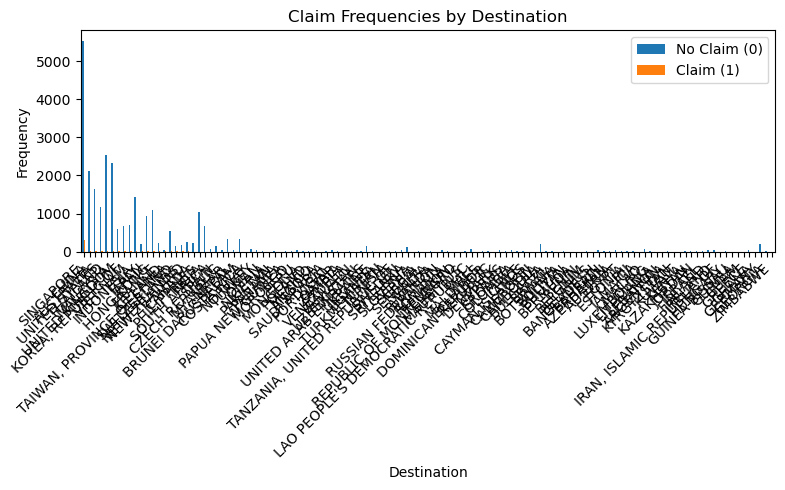

-------Proportion Table-------
Claim                                0    1 Claimed Percentage
Destination                                                   
SINGAPORE                         5536  298             63.68%
CHINA                             2104   20              4.27%
AUSTRALIA                         1632   19              4.06%
UNITED STATES                     1169   19              4.06%
THAILAND                          2549   15              3.21%
MALAYSIA                          2325   12              2.56%
UNITED KINGDOM                     594   10              2.14%
KOREA, REPUBLIC OF                 681    9              1.92%
VIET NAM                           705    7               1.5%
INDONESIA                         1431    7               1.5%
ITALY                              205    6              1.28%
JAPAN                              922    6              1.28%
HONG KONG                         1102    4              0.85%
FRANCE                  

In [113]:
claim_frequencies(df_clean, 'Destination', figsize=(8, 5))

In [115]:
HR_Destination = ['SINGAPORE', 'CHINA', 'AUSTRALIA', 'UNITED STATES', 'THAILAND', 'MALAYSIA', 'UNITED KINGDOM']

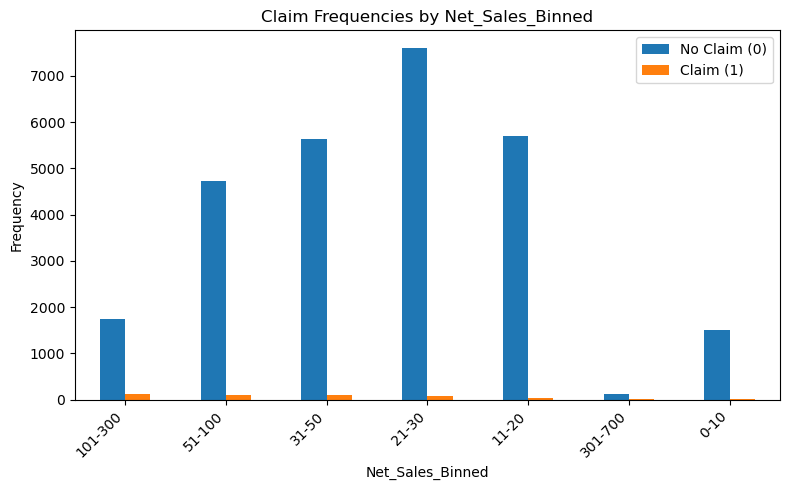

-------Proportion Table-------
Claim                0    1 Claimed Percentage
Net_Sales_Binned                              
101-300           1738  120             25.64%
51-100            4720  106             22.65%
31-50             5632   98             20.94%
21-30             7607   80             17.09%
11-20             5700   44               9.4%
301-700            121   15              3.21%
0-10              1499    5              1.07%


In [122]:
claim_frequencies(df_clean, 'Net_Sales_Binned', figsize=(8, 5))

In [123]:
HR_Net_Sales = ['101-300', '51-100', '31-50']

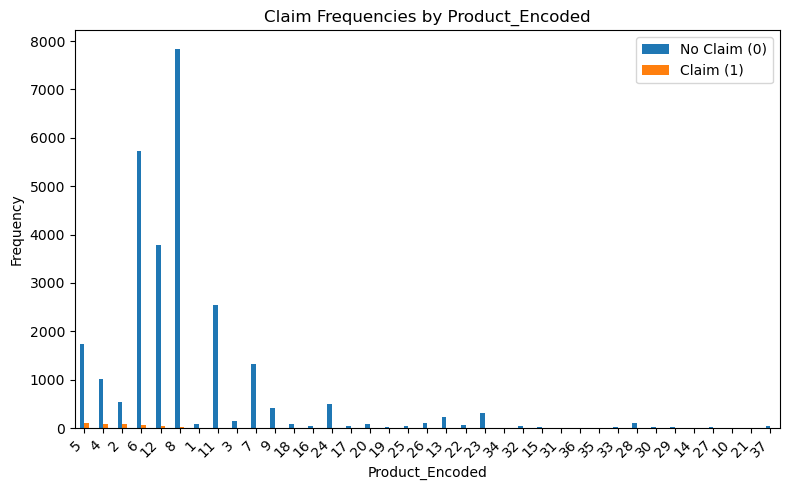

-------Proportion Table-------
Claim               0    1 Claimed Percentage
Product_Encoded                              
5                1745  108             23.08%
4                1008   82             17.52%
2                 536   80             17.09%
6                5719   61             13.03%
12               3786   48             10.26%
8                7829   20              4.27%
1                  92   13              2.78%
11               2552    8              1.71%
3                 149    6              1.28%
7                1322    5              1.07%
9                 419    5              1.07%
18                 91    5              1.07%
16                 41    5              1.07%
24                508    4              0.85%
17                 35    3              0.64%
20                 78    3              0.64%
19                 30    3              0.64%
25                 51    2              0.43%
26                 99    2              0.43%
13 

In [104]:
claim_frequencies(df_clean, 'Product_Encoded', figsize=(8, 5))

In [114]:
HR_Product_Encoded = [5, 4, 2, 6, 12, 8, 1]

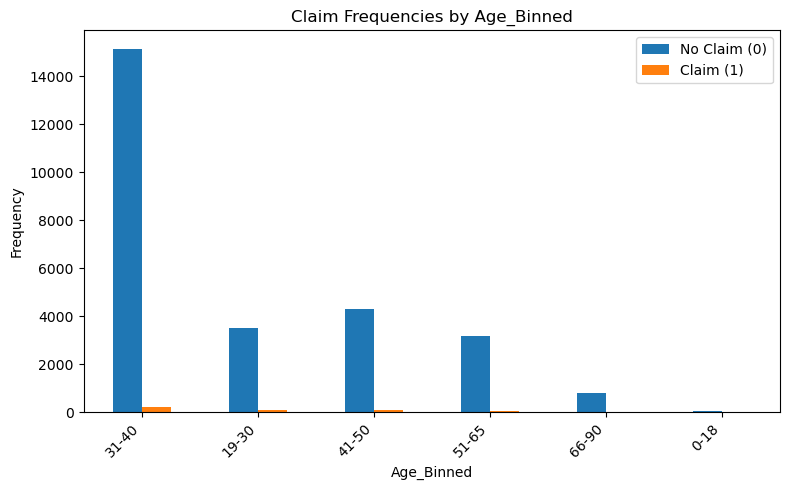

-------Proportion Table-------
Claim           0    1 Claimed Percentage
Age_Binned                               
31-40       15164  217             46.37%
19-30        3495  103             22.01%
41-50        4306   71             15.17%
51-65        3176   59             12.61%
66-90         809   15              3.21%
0-18           67    3              0.64%


In [128]:
claim_frequencies(df_clean, 'Age_Binned', figsize=(8, 5))

In [129]:
HR_Product_Encoded = ['31-40', '19-30', '41-50']

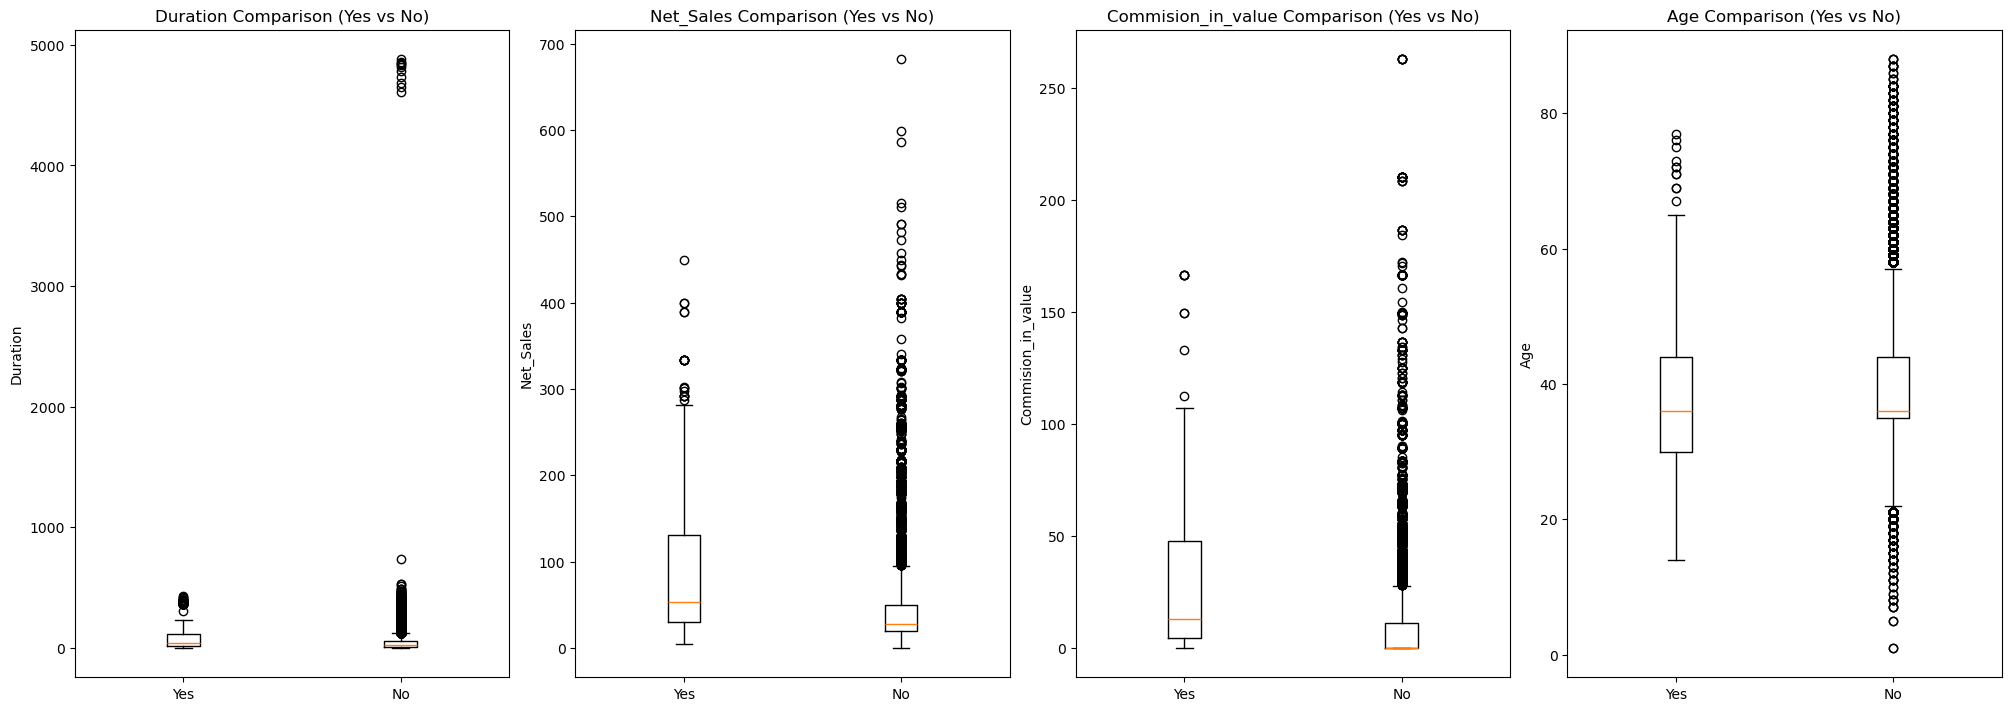

In [99]:
claim_yes = df_clean[df_clean['Claim'] == 1]
claim_no = df_clean[df_clean['Claim'] == 0]

num_cols = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']

fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 7), constrained_layout=True)

for ax, col in zip(axes, num_cols):
    ax.boxplot([claim_yes[col], claim_no[col]])
    ax.set_xticklabels(['Yes', 'No'])
    ax.set_ylabel(col)
    ax.set_title(f'{col} Comparison (Yes vs No)')

plt.show()


## 2. Machine Learning Model

### a. Feature Engineering

In [51]:
df_train = df_cleaned.copy()

#### 1). Scaling Data

Skewness of Duration: 25.00292454704775
Kurtosis of Duration: 953.7445933230925


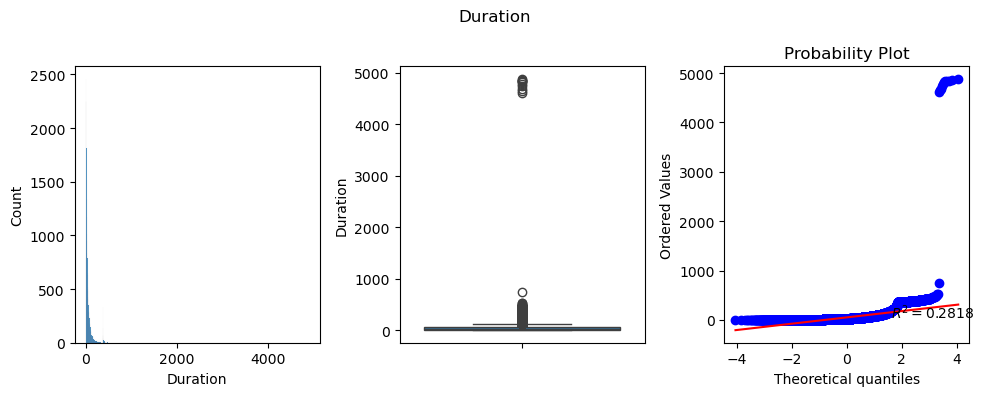

Skewness of Net_Sales: 3.5559562953811112
Kurtosis of Net_Sales: 17.801215376374536


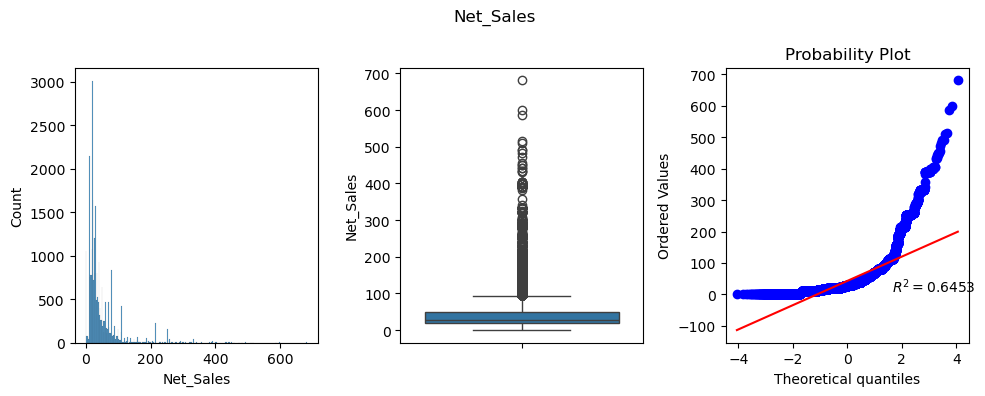

Skewness of Commision_in_value: 3.922190190412508
Kurtosis of Commision_in_value: 23.683291253156657


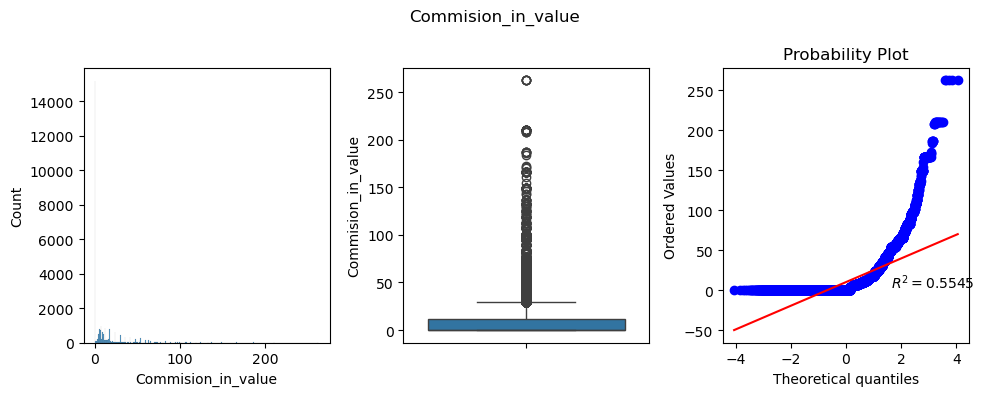

Skewness of Age: 1.1348132395840411
Kurtosis of Age: 1.6408163987246143


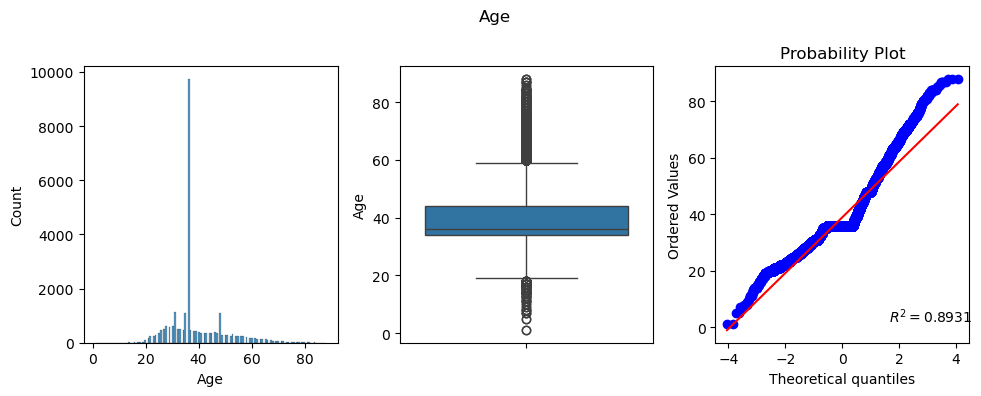

Skewness of Claim: 7.4667288816109645
Kurtosis of Claim: 53.755951843600236


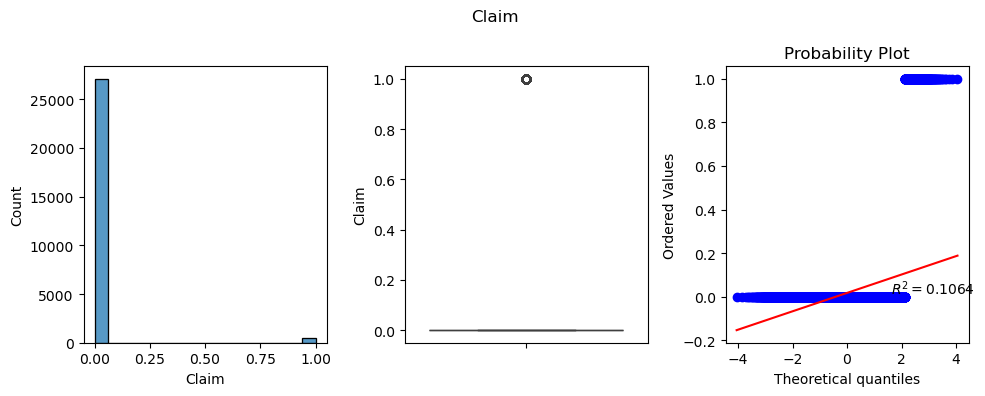

In [52]:
for col in df_train.select_dtypes(include='number').columns:
    print(f"Skewness of {col}:",df_train[col].skew())
    print(f"Kurtosis of {col}:",df_train[col].kurtosis())
    plt.figure(figsize=(10,4))
    plt.subplot(131)
    sns.histplot(df_train[col])
    plt.subplot(132)
    sns.boxplot(df_train[col])
    plt.subplot(133)
    probplot(df_train[col],plot=plt,rvalue=True,dist='norm')
    plt.suptitle(col)
    plt.tight_layout()
    plt.show()

In [53]:
def apply_transform(transformer, col):
    plt.figure(figsize=(10, 4))

    # Plot before transform
    plt.subplot(131)
    sns.histplot(df_train[col])
    plt.subplot(132)
    sns.boxplot(df_train[col])
    plt.subplot(133)
    probplot(df_train[col], rvalue=True, plot=plt, dist='norm')
    plt.suptitle(f"{col} Before Transform")
    plt.tight_layout()
    plt.show()

    # Apply the transformation
    col_tf = transformer.fit_transform(df_train[[col]])
    col_tf = np.array(col_tf).reshape(col_tf.shape[0])

    # Plot after transform
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    sns.histplot(col_tf)
    plt.subplot(132)
    sns.boxplot(col_tf)
    plt.subplot(133)
    probplot(col_tf, rvalue=True, plot=plt, dist='norm')
    plt.suptitle(f"{col} After Transform")
    plt.tight_layout()
    plt.show()

In [54]:
# Define the features want to transform
skewed_cols = ['Duration', 'Net_Sales', 'Age']

In [37]:
m

NameError: name 'm' is not defined

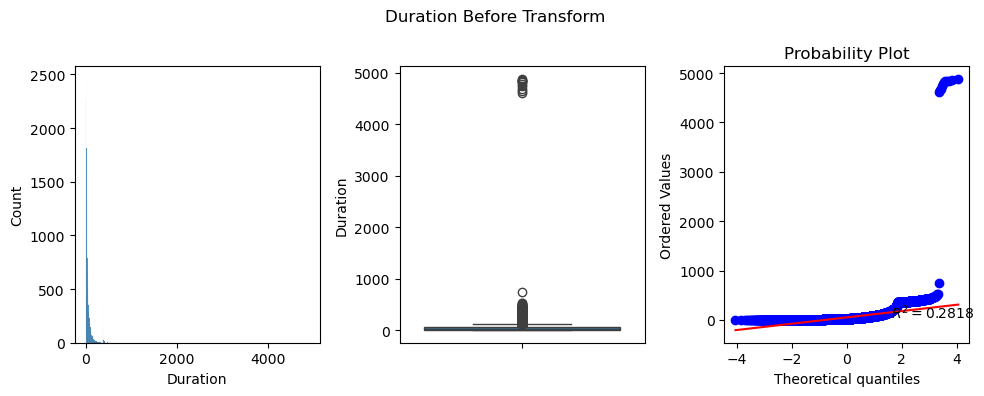

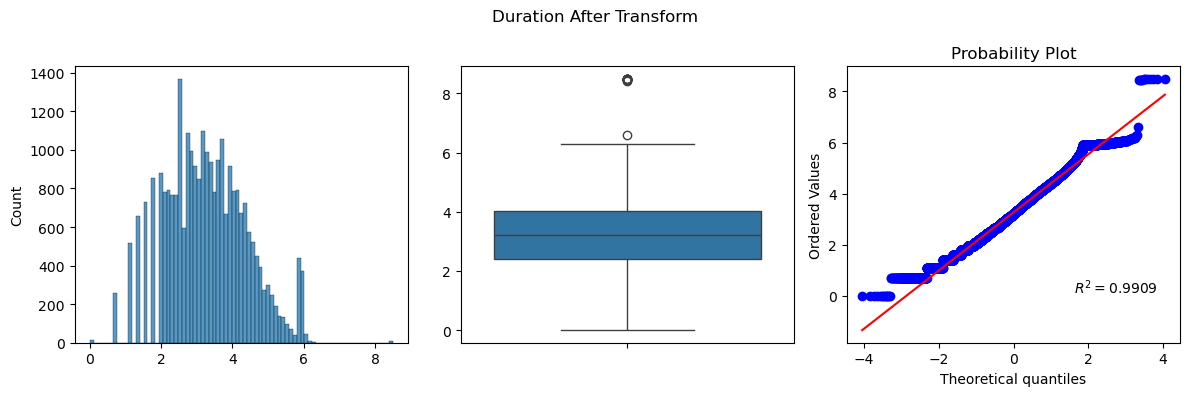

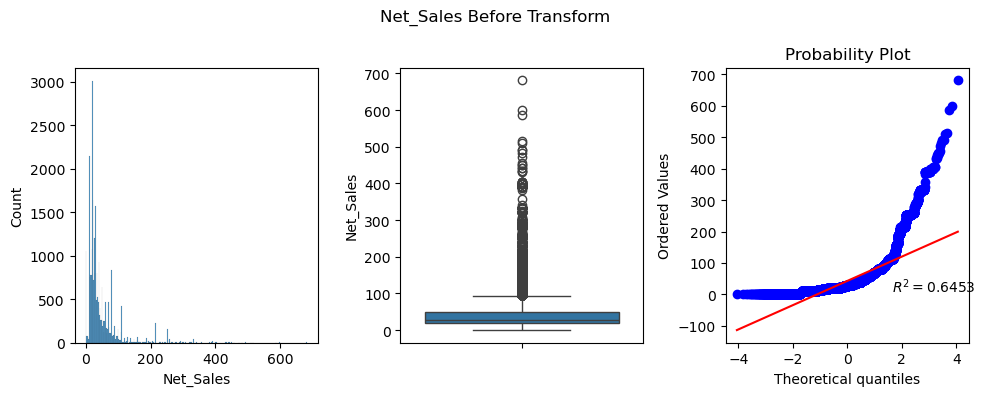

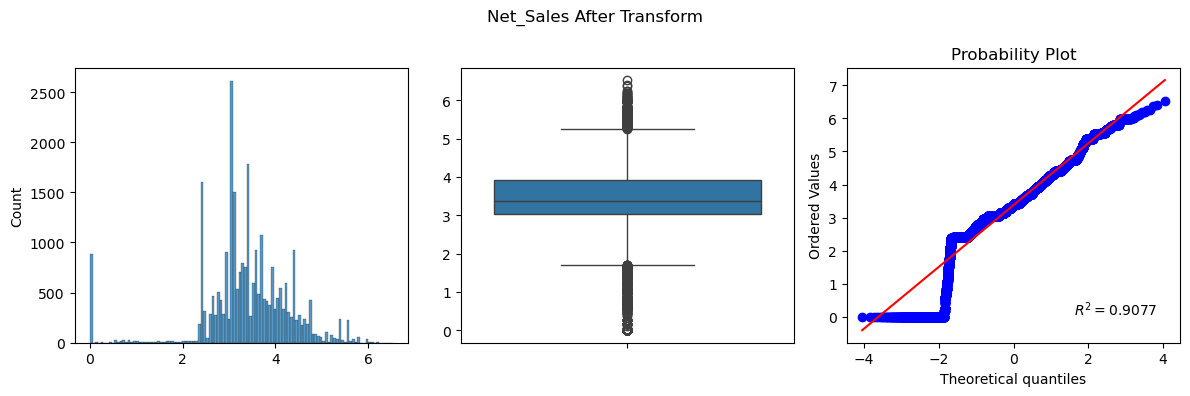

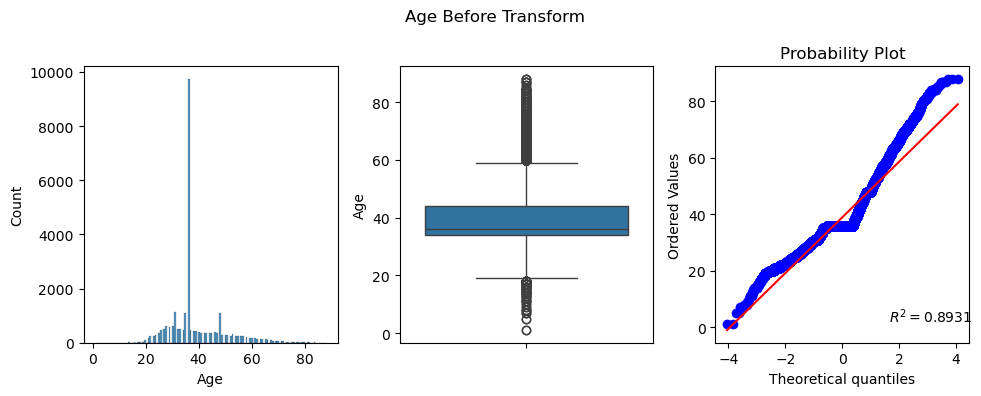

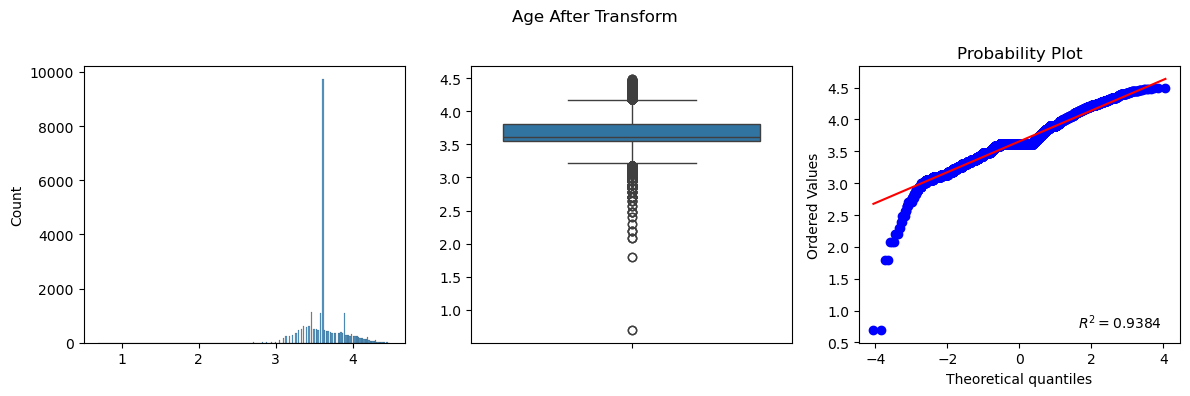

In [55]:
# Apply log transformation
for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: np.log1p(x)), col)

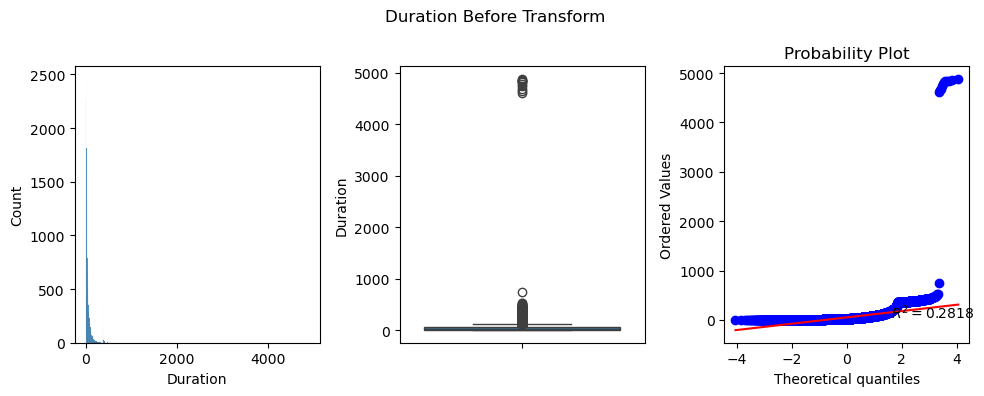

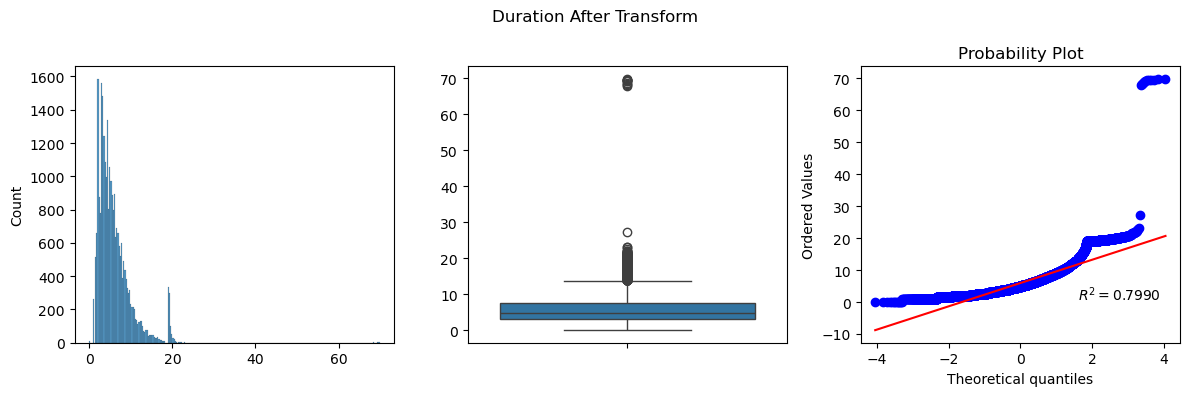

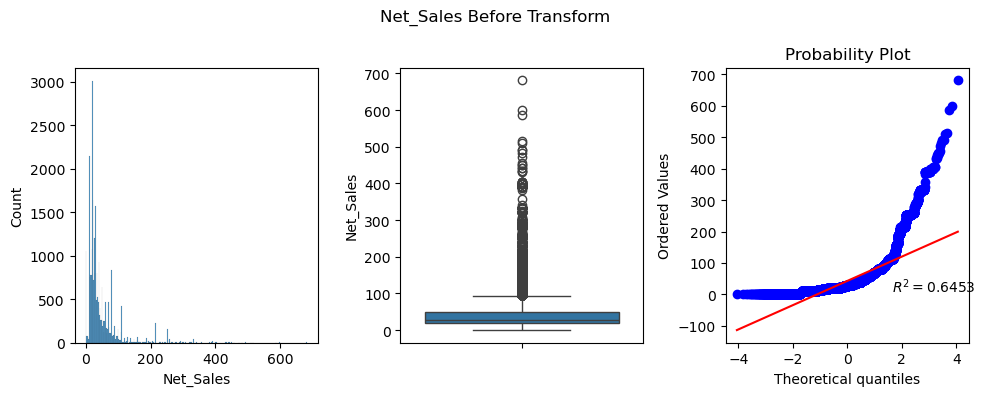

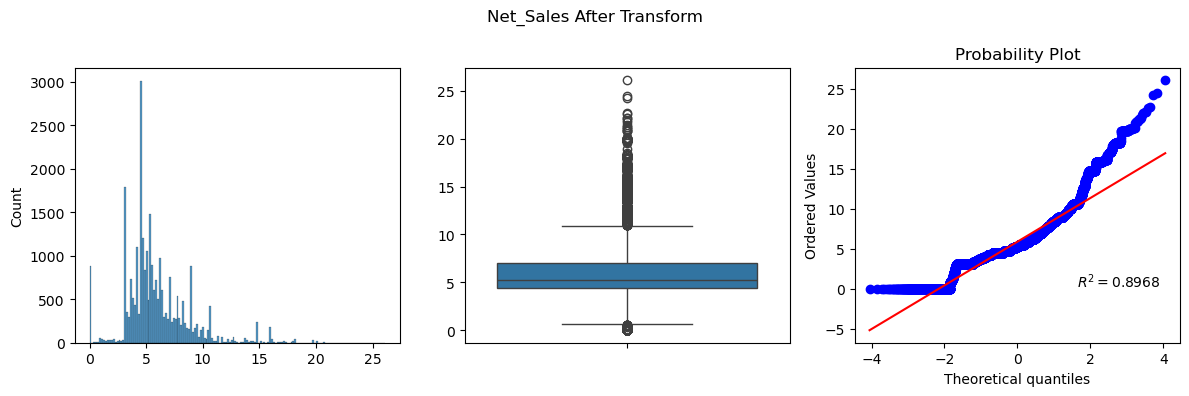

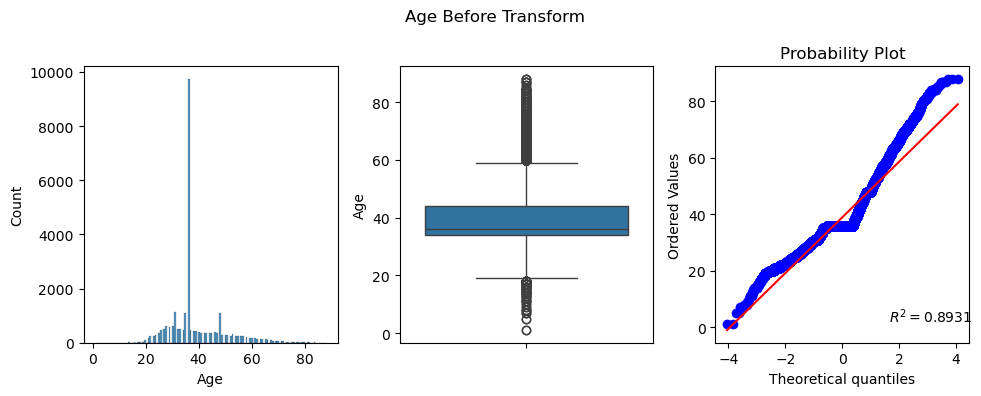

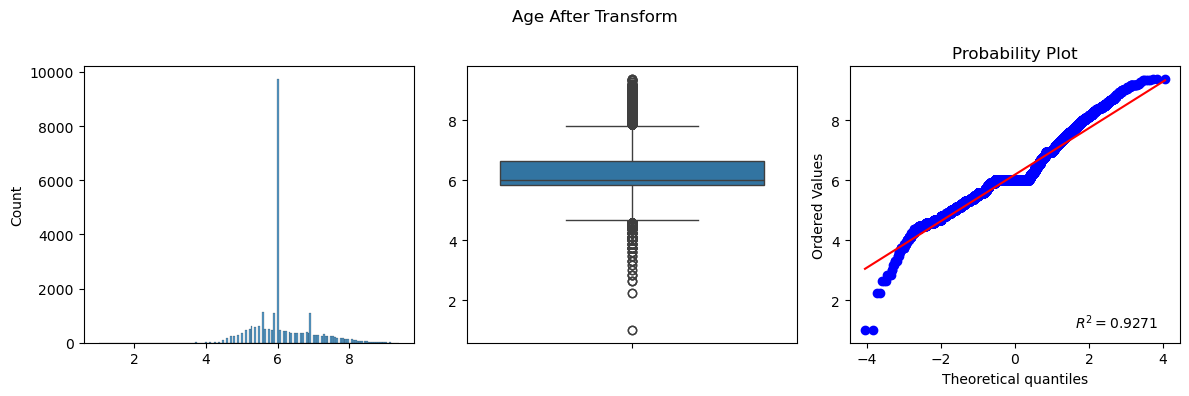

In [56]:
for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: np.sqrt(x)),col)

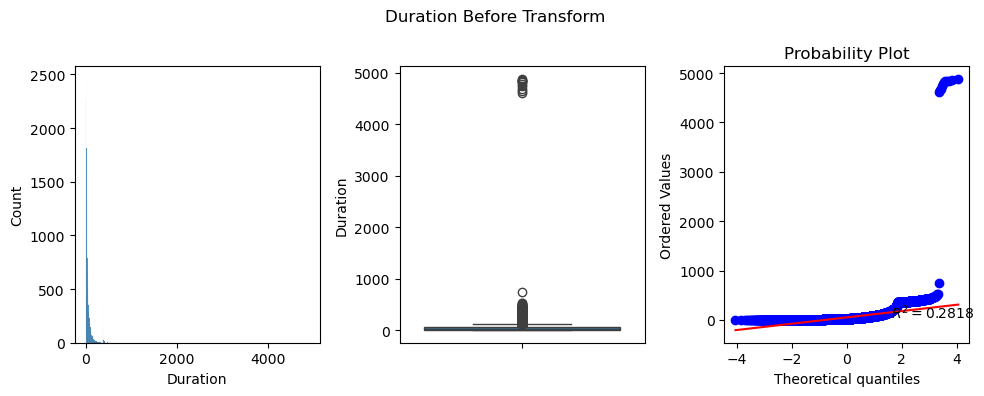

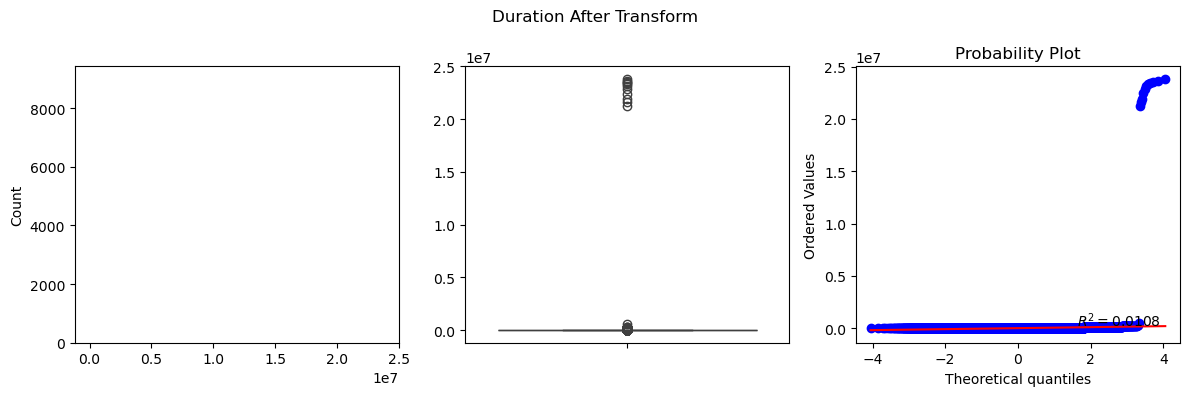

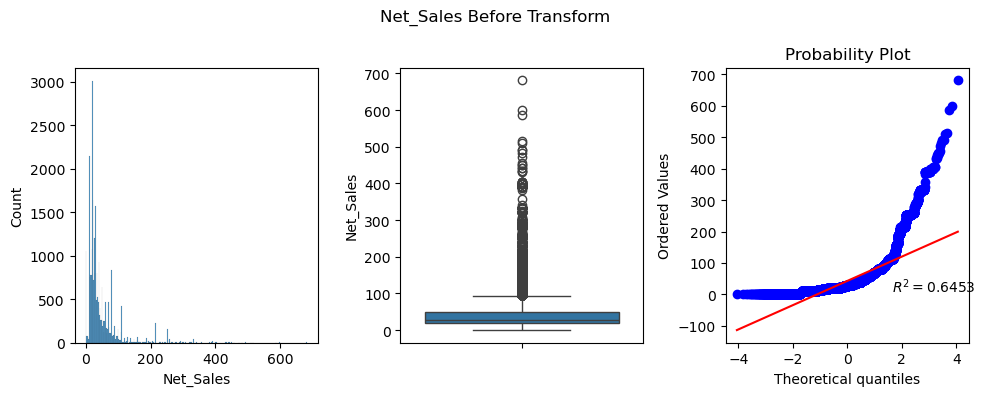

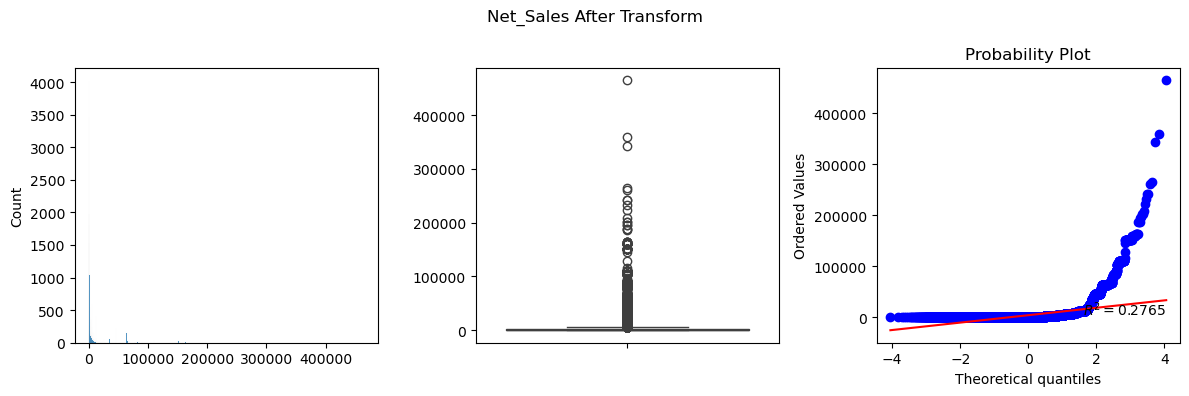

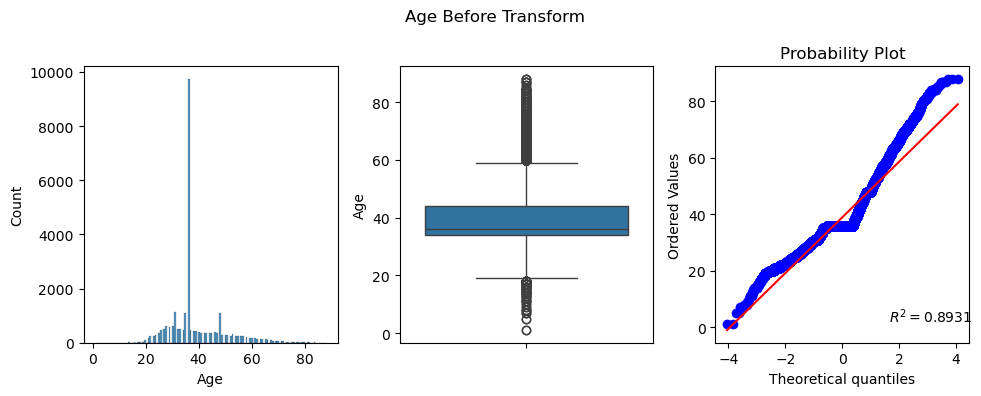

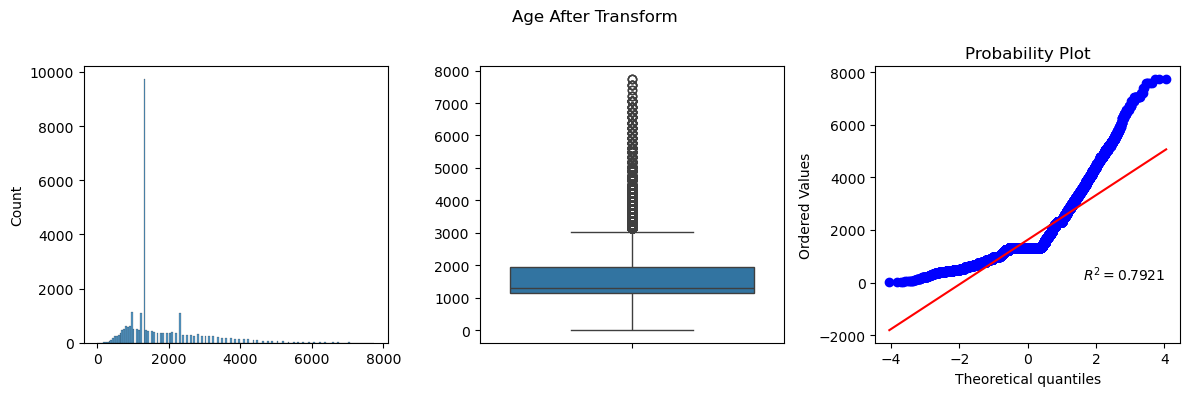

In [57]:
for col in skewed_cols:
    apply_transform(FunctionTransformer(lambda x: x**2),col)

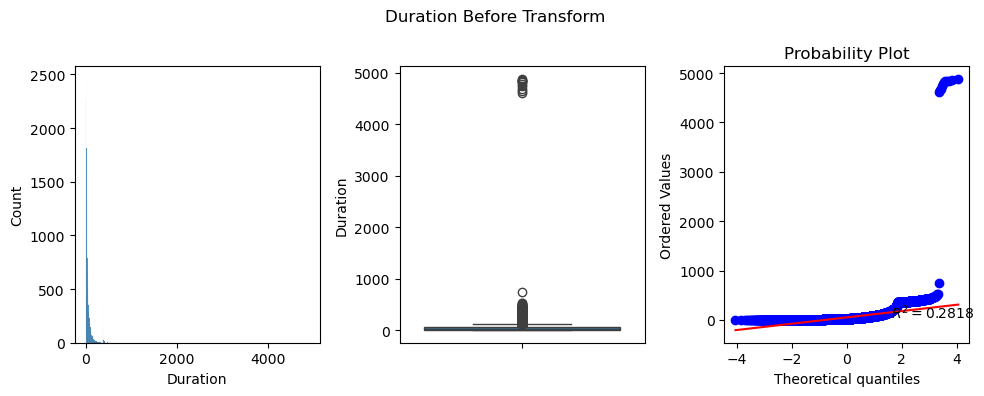

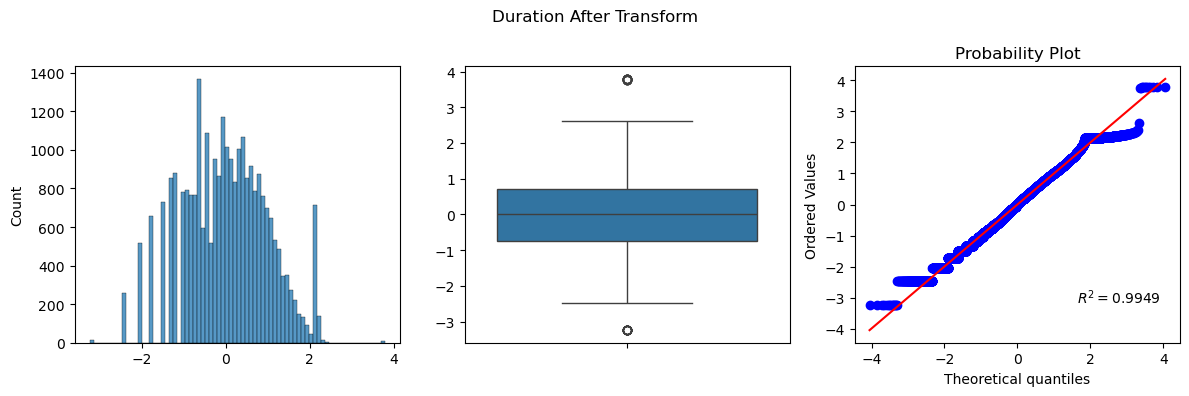

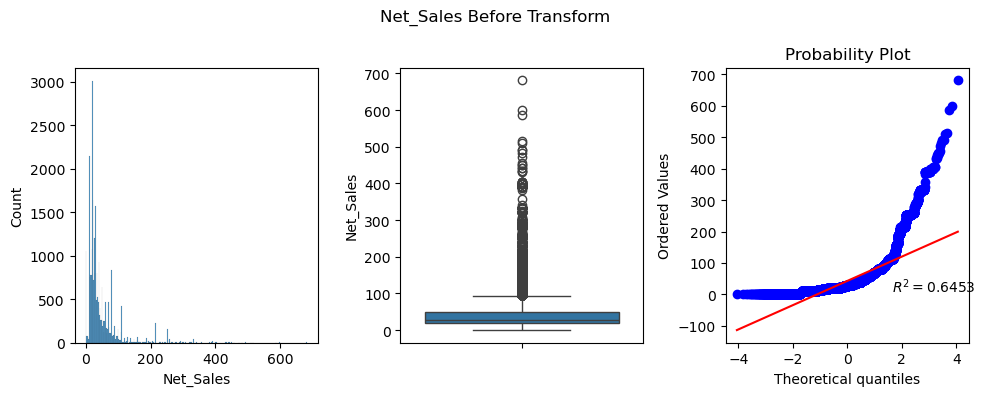

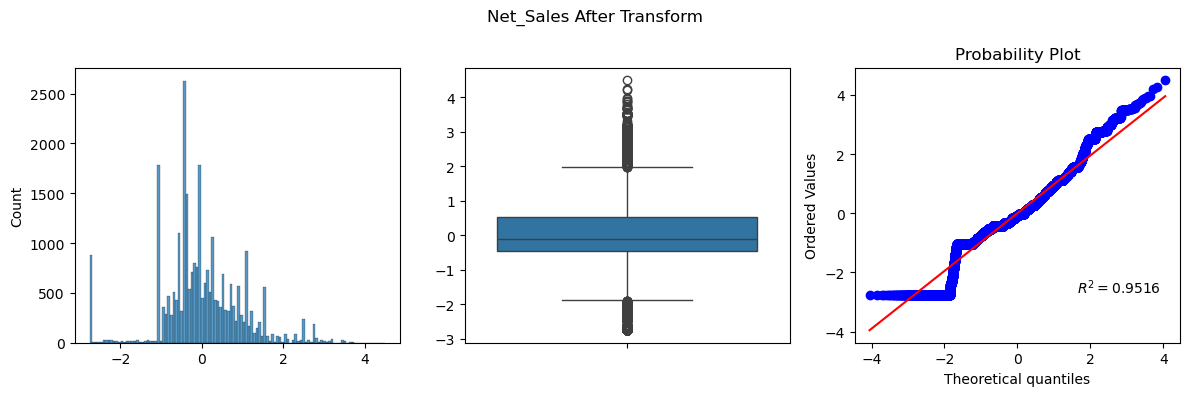

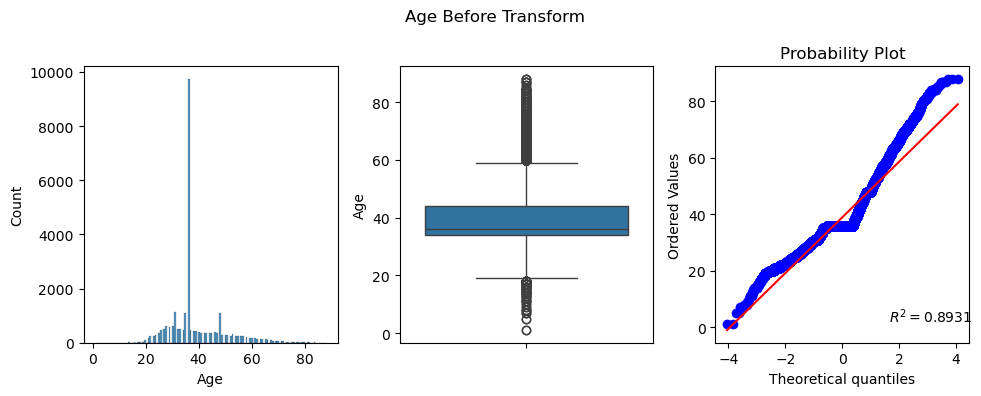

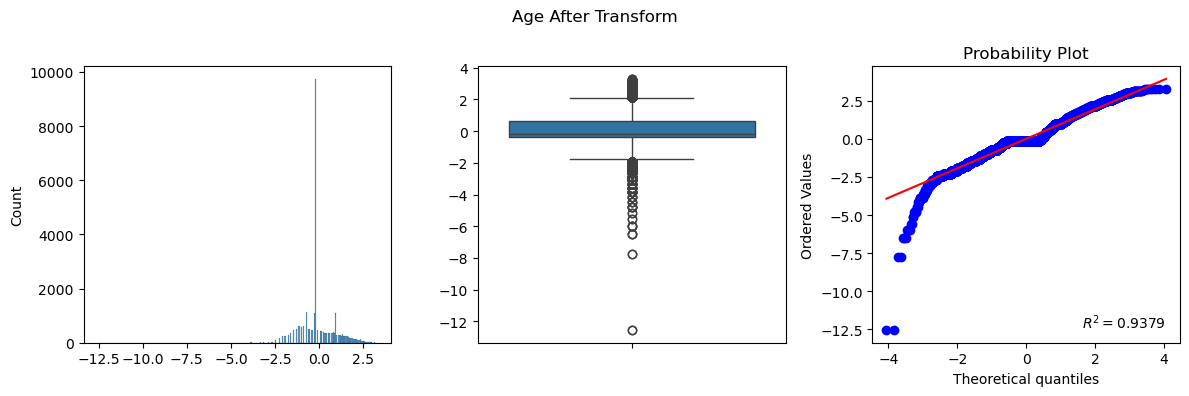

In [58]:
for col in skewed_cols:
    apply_transform(PowerTransformer(),col)

The Power Transformer i.e. the Yeo-Johnson transform produces the best results among all the feature transformations applied on the skewed columns 'Duration', "Net_Sales" and "Age".

In [ ]:
m

In [59]:
pt = PowerTransformer()

for col in skewed_cols:
    col_tf = pt.fit_transform(df_train[[col]])
    col_tf = np.array(col_tf).reshape(col_tf.shape[0])
    df_train[col] = col_tf

Skewness of Duration: 0.009789431487546903
Kurtosis of Duration: -0.31573169232840037


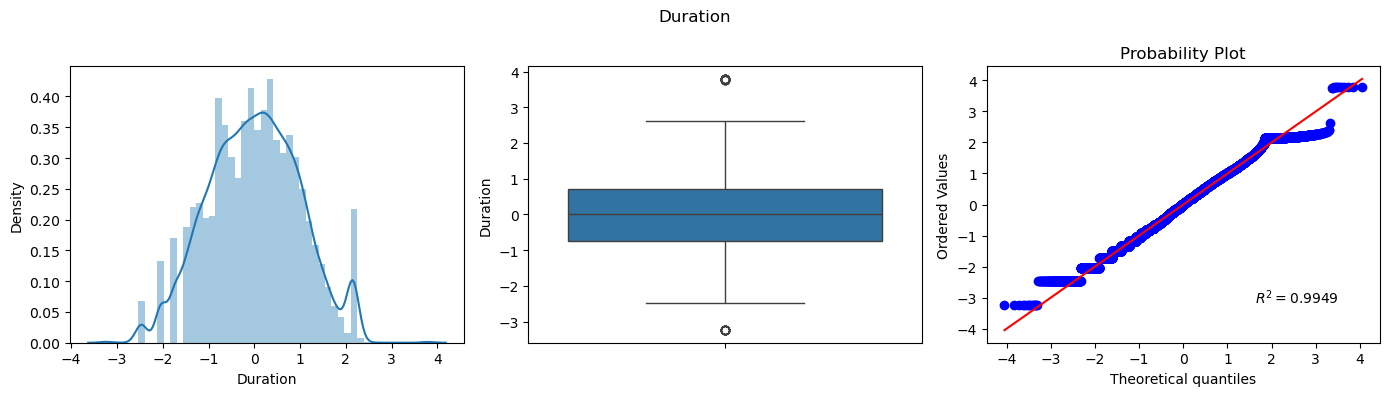

Skewness of Net_Sales: 0.10023773238839451
Kurtosis of Net_Sales: 1.6544281562335303


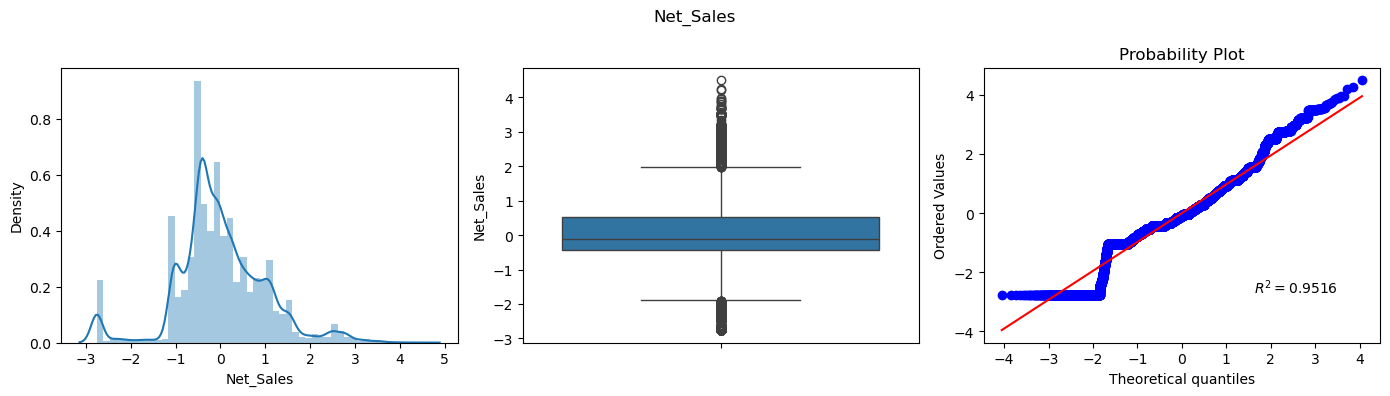

Skewness of Commision_in_value: 3.922190190412508
Kurtosis of Commision_in_value: 23.683291253156657


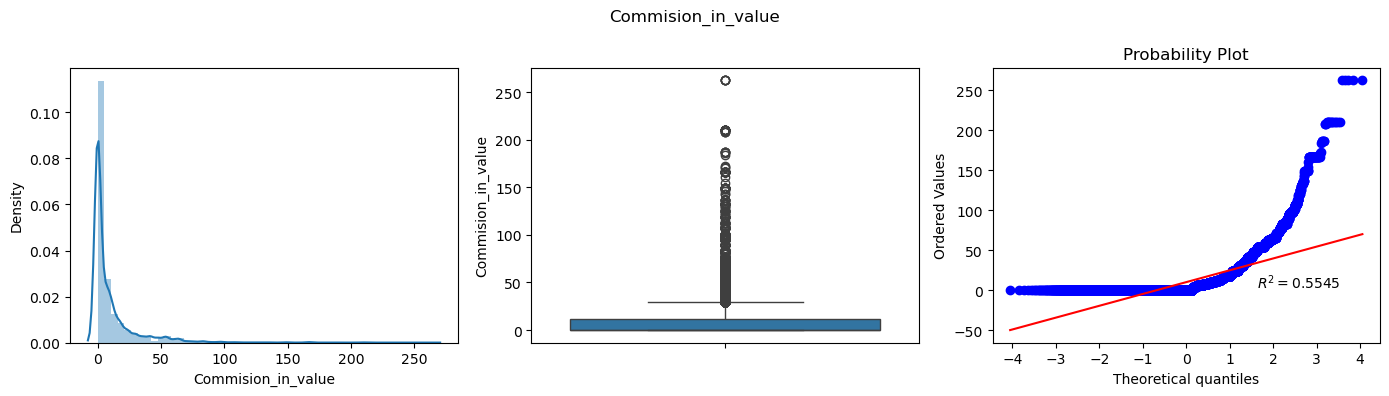

Skewness of Age: -0.009136367892355437
Kurtosis of Age: 3.051954890003061


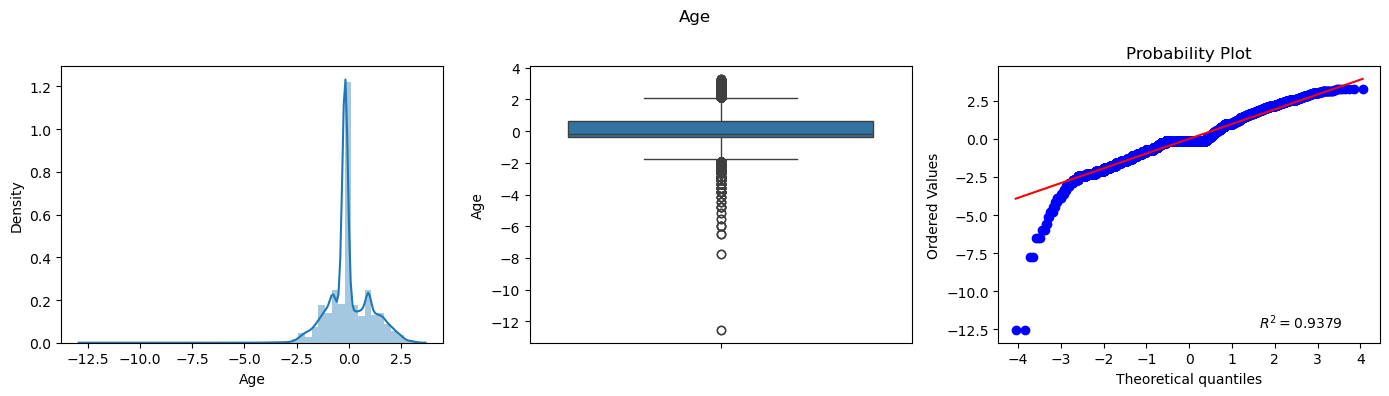

In [60]:
for col in df_train.select_dtypes(np.number).columns:
    if col != 'Claim':
        print(f"Skewness of {col}:",df_train[col].skew())
        print(f"Kurtosis of {col}:",df_train[col].kurtosis())
        plt.figure(figsize=(14,4))
        plt.subplot(131)
        sns.distplot(df_train[col])
        plt.subplot(132)
        sns.boxplot(df_train[col])
        plt.subplot(133)
        probplot(df_train[col],plot=plt,rvalue=True,dist='norm')
        plt.suptitle(col)
        plt.tight_layout()
        plt.show()

#### 2). Categorical Encoding

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27485 entries, 38872 to 41528
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                27485 non-null  object 
 1   Agency_Type           27485 non-null  object 
 2   Distribution_Channel  27485 non-null  object 
 3   Product_Name          27485 non-null  object 
 4   Duration              27485 non-null  float64
 5   Destination           27485 non-null  object 
 6   Net_Sales             27485 non-null  float64
 7   Commision_in_value    27485 non-null  float64
 8   Age                   27485 non-null  float64
 9   Claim                 27485 non-null  int32  
dtypes: float64(4), int32(1), object(5)
memory usage: 2.2+ MB


##### Nominal

* Agency, Agency_Type, Product_Name

In [62]:
# Initialize an empty DataFrame
consolidated_df = pd.DataFrame()


# Loop through each agency
for agency in df_train['Agency'].unique():
    # Calculate mean Net_Sales for each Product_Name within the current agency
    mean_sales = df_train[df_train['Agency'] == agency].groupby('Product_Name')['Net_Sales'].mean().sort_values(ascending=False)

    # Create a DataFrame from the mean_sales Series
    temp_df = mean_sales.reset_index()
    temp_df['Agency'] = agency  # Add a column for the Agency

    # Append the results to the consolidated DataFrame
    consolidated_df = pd.concat([consolidated_df, temp_df], ignore_index=True)
    consolidated_df.drop(columns='Net_Sales', inplace=True)
    consolidated_df['Product_Encoded'] = consolidated_df.index + 1

# Display the final consolidated DataFrame
display(consolidated_df)


,Product_Name,Agency,Product_Encoded
0,Annual Gold Plan,C2B,1
1,Annual Silver Plan,C2B,2
2,Gold Plan,C2B,3
3,Silver Plan,C2B,4
4,Bronze Plan,C2B,5
5,2 way Comprehensive Plan,EPX,6
6,1 way Comprehensive Plan,EPX,7
7,Cancellation Plan,EPX,8
8,Value Plan,JZI,9
9,Premier Plan,JZI,10


In [63]:
# Create a mapping dictionary
encoding_dict = {row[['Agency', 'Product_Name']].values.tobytes(): row['Product_Encoded'] for index, row in consolidated_df.iterrows()}

# Apply the encoding to df_train
df_train['Product_Encoded'] = df_train.apply(lambda row: encoding_dict.get(row[['Agency', 'Product_Name']].values.tobytes()), axis=1)
df_train.head()


,Agency,Agency_Type,Distribution_Channel,Product_Name,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded
38872,C2B,Airlines,Online,Bronze Plan,1.008933,SINGAPORE,1.243462,22.25,0.331411,0,5
20551,EPX,Travel Agency,Online,2 way Comprehensive Plan,0.637094,INDONESIA,-0.435612,0.00,-0.069087,0,6
7775,C2B,Airlines,Online,Bronze Plan,-1.509097,SINGAPORE,-0.643290,4.00,2.000594,0,5
43428,EPX,Travel Agency,Online,2 way Comprehensive Plan,-0.189372,MALAYSIA,-0.101955,0.00,-0.176057,0,6
6951,EPX,Travel Agency,Online,2 way Comprehensive Plan,-0.740235,THAILAND,-0.177585,0.00,0.035002,0,6


In [64]:
df_train.drop(columns=['Agency', 'Agency_Type', 'Product_Name'], inplace=True)
df_train.head()

,Distribution_Channel,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded
38872,Online,1.008933,SINGAPORE,1.243462,22.25,0.331411,0,5
20551,Online,0.637094,INDONESIA,-0.435612,0.00,-0.069087,0,6
7775,Online,-1.509097,SINGAPORE,-0.643290,4.00,2.000594,0,5
43428,Online,-0.189372,MALAYSIA,-0.101955,0.00,-0.176057,0,6
6951,Online,-0.740235,THAILAND,-0.177585,0.00,0.035002,0,6


* Distribution_Channel

In [65]:
df_train = pd.get_dummies(df_train, columns = ['Distribution_Channel'], dtype='int', drop_first=True)
df_train

,Duration,Destination,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded,Distribution_Channel_Online
38872,1.008933,SINGAPORE,1.243462,22.25,0.331411,0,5,1
20551,0.637094,INDONESIA,-0.435612,0.00,-0.069087,0,6,1
7775,-1.509097,SINGAPORE,-0.643290,4.00,2.000594,0,5,1
43428,-0.189372,MALAYSIA,-0.101955,0.00,-0.176057,0,6,1
6951,-0.740235,THAILAND,-0.177585,0.00,0.035002,0,6,1
...,...,...,...,...,...,...,...,...
4148,-1.174924,MALAYSIA,-0.040927,17.82,-0.069087,0,12,1
41051,0.437505,NEPAL,-0.587929,0.00,-0.176057,0,8,1
8477,0.197707,PHILIPPINES,-0.030444,0.00,-0.176057,0,8,1
36829,-2.034308,THAILAND,-1.045885,0.00,0.779720,0,8,1


* Destination

In [66]:
counts = df_train['Destination'].value_counts()
threshold = 278
remaining_cat = counts[counts <= threshold].index
destinations_encoded = pd.get_dummies(df_train['Destination'].replace(remaining_cat,'Uncommon'),drop_first=True,dtype=int,sparse=False)
destinations_encoded.sample(10)


,BRUNEI DARUSSALAM,CHINA,HONG KONG,INDIA,INDONESIA,JAPAN,"KOREA, REPUBLIC OF",MALAYSIA,MYANMAR,PHILIPPINES,SINGAPORE,"TAIWAN, PROVINCE OF CHINA",THAILAND,UNITED KINGDOM,UNITED STATES,Uncommon,VIET NAM
15841,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2203,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8858,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2479,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35385,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26510,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5069,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
16658,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11546,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [67]:
df_train = pd.concat([df_train, destinations_encoded],axis=1)
df_train.drop('Destination',axis=1,inplace=True)
display(df_train.head())

,Duration,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded,Distribution_Channel_Online,BRUNEI DARUSSALAM,CHINA,HONG KONG,INDIA,INDONESIA,JAPAN,"KOREA, REPUBLIC OF",MALAYSIA,MYANMAR,PHILIPPINES,SINGAPORE,"TAIWAN, PROVINCE OF CHINA",THAILAND,UNITED KINGDOM,UNITED STATES,Uncommon,VIET NAM
38872,1.008933,1.243462,22.25,0.331411,0,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
20551,0.637094,-0.435612,0.00,-0.069087,0,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7775,-1.509097,-0.643290,4.00,2.000594,0,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
43428,-0.189372,-0.101955,0.00,-0.176057,0,6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6951,-0.740235,-0.177585,0.00,0.035002,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


##### Ordinal

* Commision_in_value

In [68]:
df_train['Commision_in_value'] = df_train['Commision_in_value'].astype(int)
df_train['Commision_in_value'].describe()

count    27485.000000
mean         9.768965
std         19.750058
min          0.000000
25%          0.000000
50%          0.000000
75%         11.000000
max        262.000000
Name: Commision_in_value, dtype: float64

In [69]:
df_train['Commision_order'] = pd.cut(df_train['Commision_in_value'], bins=[-1, 94, 188, 285], labels=['Low', 'Medium', 'High'])
df_train['Commision_order'].value_counts()

Commision_order
Low       27234
Medium      231
High         20
Name: count, dtype: int64

In [70]:
df_train['Commision_order'] = df_train['Commision_order'].astype(object)
commission_encoder = OrdinalEncoder(categories=[['Low','Medium','High']])
df_train['Commision_order'] = commission_encoder.fit_transform(df_train[['Commision_order']])
df_train['Commision_order'] = df_train['Commision_order'].astype(int)

In [71]:
df_train

,Duration,Net_Sales,Commision_in_value,Age,Claim,Product_Encoded,Distribution_Channel_Online,BRUNEI DARUSSALAM,CHINA,HONG KONG,INDIA,INDONESIA,JAPAN,"KOREA, REPUBLIC OF",MALAYSIA,MYANMAR,PHILIPPINES,SINGAPORE,"TAIWAN, PROVINCE OF CHINA",THAILAND,UNITED KINGDOM,UNITED STATES,Uncommon,VIET NAM,Commision_order
38872,1.008933,1.243462,22,0.331411,0,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
20551,0.637094,-0.435612,0,-0.069087,0,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7775,-1.509097,-0.643290,4,2.000594,0,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
43428,-0.189372,-0.101955,0,-0.176057,0,6,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6951,-0.740235,-0.177585,0,0.035002,0,6,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4148,-1.174924,-0.040927,17,-0.069087,0,12,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
41051,0.437505,-0.587929,0,-0.176057,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
8477,0.197707,-0.030444,0,-0.176057,0,8,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
36829,-2.034308,-1.045885,0,0.779720,0,8,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### b. Modelling and Evaluation

In [73]:
df_encoded = df_train.copy()

In [74]:
X = df_encoded.drop('Claim',axis=1)
y = df_encoded['Claim']

In [75]:
oversampler = SMOTE()
X, y = oversampler.fit_resample(X, y)

In [76]:
print("Distribution of class in target variable y (Claim):", y.value_counts())

Distribution of class in target variable y (Claim): Claim
0    27017
1    27017
Name: count, dtype: int64


In [77]:
print("New shape of the dataset:",X.shape)

New shape of the dataset: (54034, 24)


In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
import lightgbm as lgb
import time

# Assuming X_train, y_train are already defined and preprocessed as per your dataset details

# Define the classifier models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

# Create a single pipeline instance with feature selection and a placeholder for classifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', LogisticRegression())  # Placeholder
])

# Define parameter grid differently for each classifier
param_grid = [
    {'feature_selection__k': [5, 10, 15, 20], 'classifier': [models['Logistic Regression']], 'classifier__C': [100, 10, 1, 0.1]},
    {'feature_selection__k': [5, 10, 15, 20], 'classifier': [models['Decision Tree']], 'classifier__max_depth': [5, 10, 15]},
    {'feature_selection__k': [5, 10, 15, 20], 'classifier': [models['Random Forest']], 'classifier__n_estimators': [50, 100, 150]},
    {'feature_selection__k': [5, 10, 15, 20], 'classifier': [models['KNN']], 'classifier__n_neighbors': [5, 15, 25]},
    {'feature_selection__k': [5, 10, 15, 20], 'classifier': [models['XGBoost']], 'classifier__n_estimators': [50, 100]},
    {'feature_selection__k': [5, 10, 15, 20], 'classifier': [models['LightGBM']], 'classifier__num_leaves': [31, 62]}
]

# Configure GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

# Jika ingin menggunakan beberapa scorer:
scoring = {'AUC': 'roc_auc', 'F1': 'f1'}
gscv = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring=scoring, refit='AUC')

# Track fitting time
start_time = time.time()

# Fit GridSearchCV to the data
gscv.fit(X_train, y_train)

end_time = time.time()
fitting_time = end_time - start_time

print(f"Fitting time: {fitting_time:.2f} seconds")
print("Best score:", gscv.best_score_)
print("Best parameters:", gscv.best_params_)


[LightGBM] [Info] Number of positive: 18911, number of negative: 18912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 971
[LightGBM] [Info] Number of data points in the train set: 37823, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499987 -> initscore=-0.000053
[LightGBM] [Info] Start training from score -0.000053
Fitting time: 179.06 seconds
Best score: 0.9946055332566811
Best parameters: {'classifier': LGBMClassifier(), 'classifier__num_leaves': 62, 'feature_selection__k': 20}


In [81]:
gscv.best_estimator_

Pipeline(steps=[('feature_selection', SelectKBest(k=20)),
                ('classifier', LGBMClassifier(num_leaves=62))])

In [161]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27485 entries, 38872 to 41528
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Duration                     27485 non-null  float64
 1   Net_Sales                    27485 non-null  float64
 2   Commision_in_value           27485 non-null  int32  
 3   Age                          27485 non-null  float64
 4   Claim                        27485 non-null  int32  
 5   Product_Encoded              27485 non-null  int64  
 6   Distribution_Channel_Online  27485 non-null  int32  
 7   BRUNEI DARUSSALAM            27485 non-null  int32  
 8   CHINA                        27485 non-null  int32  
 9   HONG KONG                    27485 non-null  int32  
 10  INDIA                        27485 non-null  int32  
 11  INDONESIA                    27485 non-null  int32  
 12  JAPAN                        27485 non-null  int32  
 13  KOREA, REPUBLIC O

In [163]:
# # Model dan parameter tuning
# models = {
#     'Logistic Regression': (LogisticRegression(random_state=42, solver='liblinear'),
#                             {'C': uniform(0.1, 10), 'penalty': ['l1', 'l2']}),
#     'Random Forest': (RandomForestClassifier(random_state=42),
#                       {'n_estimators': randint(100, 1000),
#                        'max_depth': randint(5, 30),
#                        'min_samples_split': randint(2, 20),
#                        'min_samples_leaf': randint(1, 10)}),
#     'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False),
#                 {'n_estimators': randint(100, 1000),
#                  'max_depth': randint(3, 10),
#                  'learning_rate': uniform(0.01, 0.3)}),
#     'SVM': (SVC(random_state=42, probability=True),
#             {'C': uniform(0.1, 10),
#              'kernel': ['rbf', 'linear'],
#              'gamma': ['scale', 'auto']}),
#     'KNN': (KNeighborsClassifier(),
#             {'n_neighbors': randint(3, 20),
#              'weights': ['uniform', 'distance']}),
#     'Decision Tree': (DecisionTreeClassifier(random_state=42),
#                       {'max_depth': randint(5, 30),
#                        'min_samples_split': randint(2, 20),
#                        'min_samples_leaf': randint(1, 10)}),
#     'Naive Bayes': (GaussianNB(),
#                     {'var_smoothing': uniform(1e-10, 1e-8)}),
#     'LightGBM': (LGBMClassifier(random_state=42),
#                  {'n_estimators': randint(100, 1000),
#                   'max_depth': randint(3, 10),
#                   'learning_rate': uniform(0.01, 0.3)}),
#     'CatBoost': (CatBoostClassifier(random_state=42, verbose=0),
#                  {'iterations': randint(100, 1000),
#                   'depth': randint(4, 10),
#                   'learning_rate': uniform(0.01, 0.3)}),
#     'Gradient Boosting': (GradientBoostingClassifier(random_state=42),
#                           {'n_estimators': randint(100, 1000),
#                            'max_depth': randint(3, 10),
#                            'learning_rate': uniform(0.01, 0.3)})
# }

# # Fungsi evaluasi
# def evaluate_model(y_true, y_pred, y_pred_proba):
#     return {
#         'Accuracy': accuracy_score(y_true, y_pred),
#         'Precision': precision_score(y_true, y_pred),
#         'Recall': recall_score(y_true, y_pred),
#         'F1-score': f1_score(y_true, y_pred),
#         'AUC-ROC': roc_auc_score(y_true, y_pred_proba)
#     }

# # Inisialisasi dictionary untuk menyimpan hasil
# results = {}

# # Looping untuk tuning setiap model
# for name, (model, params) in models.items():
#     print(f"\nTuning {name}...")

#     # Randomized Search CV
#     random_search = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=-1, random_state=42, scoring='f1')
    
#     # Measure fitting time
#     start_time = time.time()
#     random_search.fit(X_train, y_train)  # Menggunakan X_train dan y_train
#     fit_time = time.time() - start_time
    
#     # Measure prediction time
#     start_time = time.time()
#     y_pred = random_search.predict(X_val)  # Menggunakan X_val untuk prediksi
#     y_pred_proba = random_search.predict_proba(X_val)[:, 1]  # Mengambil probabilitas prediksi kelas positif
#     predict_time = time.time() - start_time
    
#     # Evaluate model
#     eval_results = evaluate_model(y_val, y_pred, y_pred_proba)
#     eval_results['Fit Time'] = fit_time
#     eval_results['Predict Time'] = predict_time
#     results[name] = eval_results
    
#     print(f"Best parameters for {name}: {random_search.best_params_}")
#     print(f"Best cross-validation score for {name}: {random_search.best_score_:.4f}")
#     print(f"Test set results for {name}:")
#     for metric, value in eval_results.items():
#         print(f"{metric}: {value:.4f}")

# # Output semua hasil
# import pandas as pd
# results_df = pd.DataFrame(results).T  # Mengonversi hasil ke DataFrame
# print(results_df)



Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 0.6641157902710025, 'penalty': 'l2'}
Best cross-validation score for Logistic Regression: 0.8222
Test set results for Logistic Regression:
Accuracy: 0.8120
Precision: 0.7793
Recall: 0.8706
F1-score: 0.8224
AUC-ROC: 0.8748
Fit Time: 30.0679
Predict Time: 0.0084

Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 413}
Best cross-validation score for Random Forest: 0.9503
Test set results for Random Forest:
Accuracy: 0.9552
Precision: 0.9350
Recall: 0.9784
F1-score: 0.9562
AUC-ROC: 0.9913
Fit Time: 718.1160
Predict Time: 2.2350

Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.14682099526511078, 'max_depth': 9, 'n_estimators': 662}
Best cross-validation score for XGBoost: 0.9623
Test set results for XGBoost:
Accuracy: 0.9676
Precision: 0.9616
Recall: 0.9741
F1-score: 0.9678
AUC-ROC: 0.9959
Fit Time: 100.10

# Rule Based

Berikut adalah rule-based yang dapat digunakan:
1. Durasi Perjalanan:
    * Jika 'Duration' > 14 hari, risiko klaim meningkat.
    * Jika 'Duration' > 30 hari, risiko klaim sangat tinggi.
2. Destinasi:
    * Jika 'Destination' adalah negara dengan risiko tinggi (misalnya, daerah konflik atau dengan layanan kesehatan terbatas), kemungkinan klaim lebih tinggi.
3. Usia:
    * Jika 'Age' < 18 atau > 65, risiko klaim lebih tinggi.
4. Jenis Produk:
    * Jika 'Product Name' mencakup perlindungan komprehensif, kemungkinan klaim lebih tinggi.
5. Nilai Polis:
    * Jika 'Net Sales' tinggi, kemungkinan klaim juga meningkat karena perlindungan yang lebih luas.
6. Gender:
    * Berdasarkan data historis, jika salah satu gender memiliki tingkat klaim lebih tinggi, pertimbangkan faktor ini.
7. Saluran Distribusi:
    * Jika 'Distribution Channel' tertentu memiliki sejarah klaim tinggi, pertimbangkan ini sebagai faktor risiko.
8. Tipe Agen:
    * Jika 'Agency Type' tertentu cenderung menjual polis dengan tingkat klaim tinggi, pertimbangkan ini dalam penilaian.
Rule-based prediction:
1. Risiko Tinggi (kemungkinan besar akan klaim):
    * Durasi > 30 hari ATAU
    * Destinasi berisiko tinggi ATAU
    * Usia < 18 atau > 65 DAN Durasi > 14 hari ATAU
    * Product Name mencakup perlindungan komprehensif DAN Net Sales di atas rata-rata
2. Risiko Menengah:
    * Durasi antara 14-30 hari ATAU
    * Usia antara 50-65 atau 18-25 ATAU
    * Product Name standar dengan beberapa perlindungan tambahan
3. Risiko Rendah (kemungkinan kecil akan klaim):
    * Durasi < 14 hari DAN
    * Destinasi umum dengan risiko rendah DAN
    * Usia antara 25-50 tahun DAN
    * Product Name standar tanpa perlindungan tambahan
Untuk implementasi yang lebih akurat, Anda perlu:
1. Menentukan threshold spesifik untuk 'Net Sales' dan 'Commision (in value)' berdasarkan data historis.
2. Mengklasifikasikan 'Destination' berdasarkan tingkat risiko.
3. Mengkategorikan 'Product Name' berdasarkan tingkat perlindungan.
4. Menganalisis data historis untuk melihat korelasi antara 'Agency', 'Agency Type', dan 'Distribution Channel' dengan tingkat klaim.

In [82]:
df_clean = df.copy()

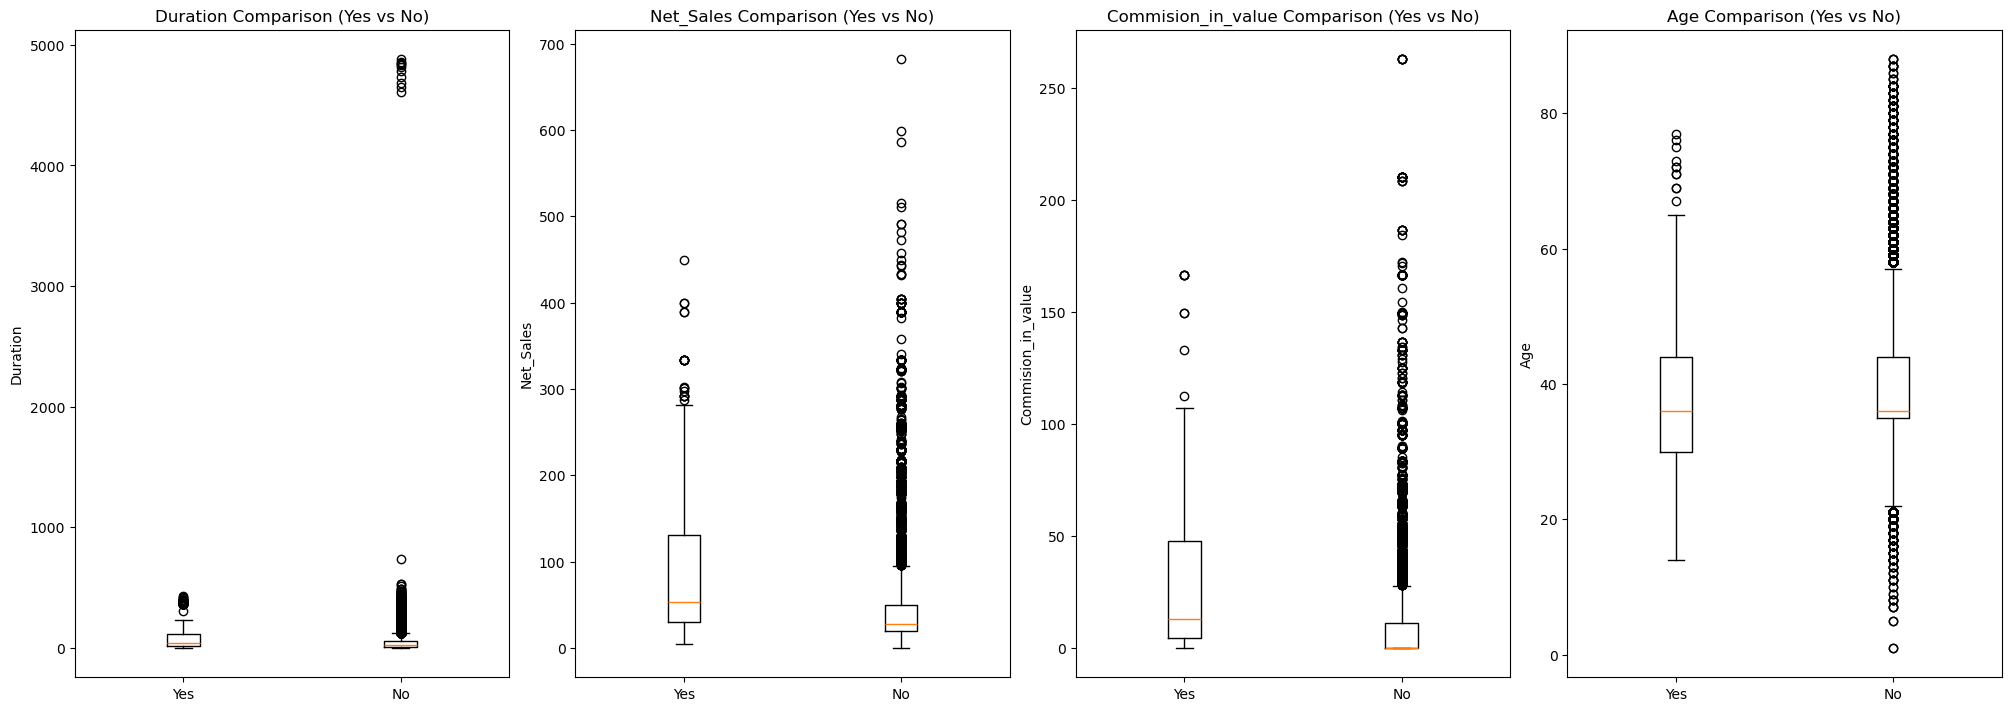

In [85]:
claim_yes = df_clean[df_clean['Claim'] == 1]
claim_no = df_clean[df_clean['Claim'] == 0]

num_cols = ['Duration', 'Net_Sales', 'Commision_in_value', 'Age']

fig, axes = plt.subplots(1, len(num_cols), figsize=(20, 7), constrained_layout=True)

for ax, col in zip(axes, num_cols):
    ax.boxplot([claim_yes[col], claim_no[col]])
    ax.set_xticklabels(['Yes', 'No'])
    ax.set_ylabel(col)
    ax.set_title(f'{col} Comparison (Yes vs No)')

plt.show()


In [84]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.
